# Dataset summary

The dataset for the scope of this project consists of daily stock data gathered throughout last 10 years, downloaded from the site stooq.pl, which encompasses information about three companies: 
- Gooogle
- Amazon
- Microsoft

Data not only contains missing points (days for which data points are non-existent) but also by its nature is prone to anomalies, in that case:
- outliers
- shifts in trend and/or seasonality at certain points in time
- variability in both trend, seasonality, and variability of points, measured by the standard deviation

# Task summary

We aim to develop a statistical model which can accurately predict the last year of data, based on the events previously observed in the timeline. To clarify we wish to be able to <u>predict the last 366 days of our dataset based on all of the previous days, as accurately as possible.</u>
To quantify accuracy we decided to use <u>mean squared error</u> metric, calculated for model predictions on the test set.

# Data download

In [137]:
import datetime
import pandas as pd
import numpy as np
from os import path, mkdir, listdir, getcwd as get_current_directory
from pandas_datareader import DataReader
from joblib import Parallel, delayed, dump as joblib_dump, load as joblib_load
from tqdm import tqdm
from sklearn.metrics import mean_squared_error as mse

from python_scripts.download import download_stock_data_in_parallel
from python_scripts.load_data import load_stock_data

In [2]:
DEFAULT_STOCK_DOWNLOAD_FOLDER_NAME = "stock_data_download"

start_date = datetime.datetime(2010, 6, 1)
end_date = datetime.datetime(2021, 6, 30)
start_date_string = str(start_date.date())
end_date_string = str(end_date.date())

list_of_stocks = ['MSFT', 'GOOGL', 'AMZN',]

In [3]:
download_stock_data_in_parallel(
    stock_labels_list=list_of_stocks,
    root_folder_path=None,
    save_folder_name=DEFAULT_STOCK_DOWNLOAD_FOLDER_NAME,
    start_date=start_date_string,
    end_date=end_date_string,
    stock_data_prefix="stock_data",
    data_source="stooq",
    n_jobs=3,
)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 52.26it/s]


1

In [4]:
stocks_dictionary = load_stock_data(
    stock_labels_list=list_of_stocks,
    start_date=start_date_string,
    end_date=end_date_string,
    load_folder_name=DEFAULT_STOCK_DOWNLOAD_FOLDER_NAME,
    root_folder_path=None, 
    stock_data_prefix="stock_data"
)

Now we can explore the data, to get hang on the problems, which could impact our attempts to determine valid models.

In [5]:
for stock, stock_values in stocks_dictionary.items():
    print(f"Stock: {stock} has {(stock_values.index.max()-stock_values.index.min()).days - stock_values.shape[0]} missing days of data")

Stock: msft has 1256 missing days of data
Stock: amzn has 1256 missing days of data
Stock: googl has 1256 missing days of data


Stocks have following plots: 



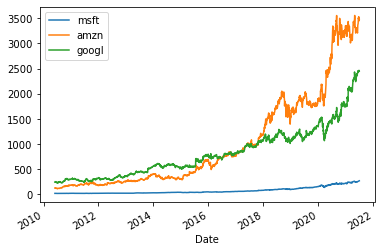

In [6]:
print(f"Stocks have following plots: \n")
for stock, stock_values in stocks_dictionary.items():
    stock_values.rename(columns = {"High":stock})[stock].plot(legend = True)

In [7]:
stocks_dictionary_inferred = {
    stock: stock_values.resample(rule = 'D').asfreq().interpolate(method = 'spline', order = 3, limit = 7, limit_direction = 'both')
    for stock, stock_values in stocks_dictionary.items()
}

In [8]:
from python_scripts.analytic_functions import get_expanding_means_dataframe, get_expanding_stds_dataframe, get_rolling_means_dataframe, get_rolling_stds_dataframe

<AxesSubplot:xlabel='Date'>

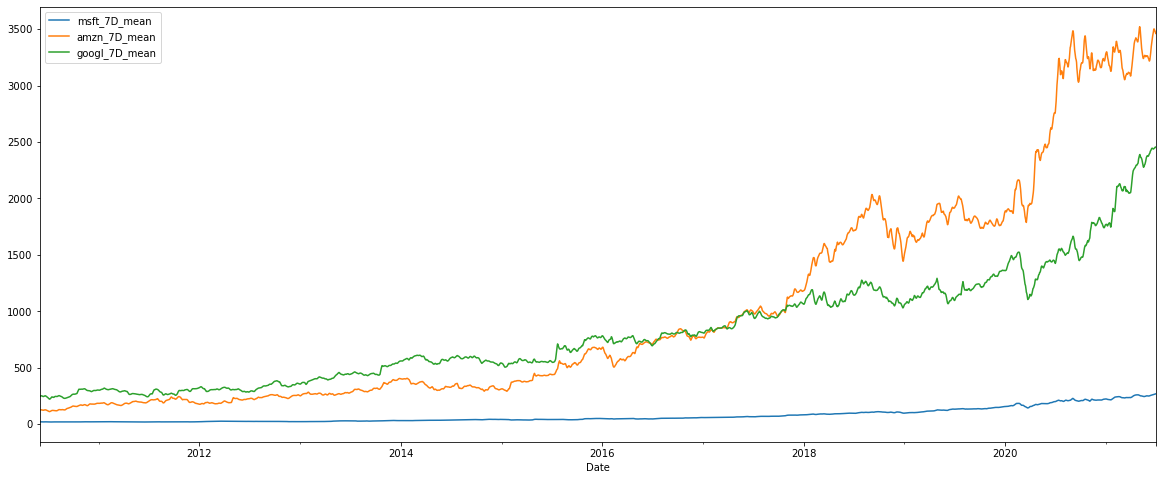

In [9]:
stocks_rolling_means = get_rolling_means_dataframe(stocks_dictionary_inferred)
stocks_rolling_means.plot(figsize=(20,8))

From the plot above we can clearly see that both mean and variability of data changes over time for amazon and google stocks. Even more clearly this behavior has been illustrated below.

<AxesSubplot:xlabel='Date'>

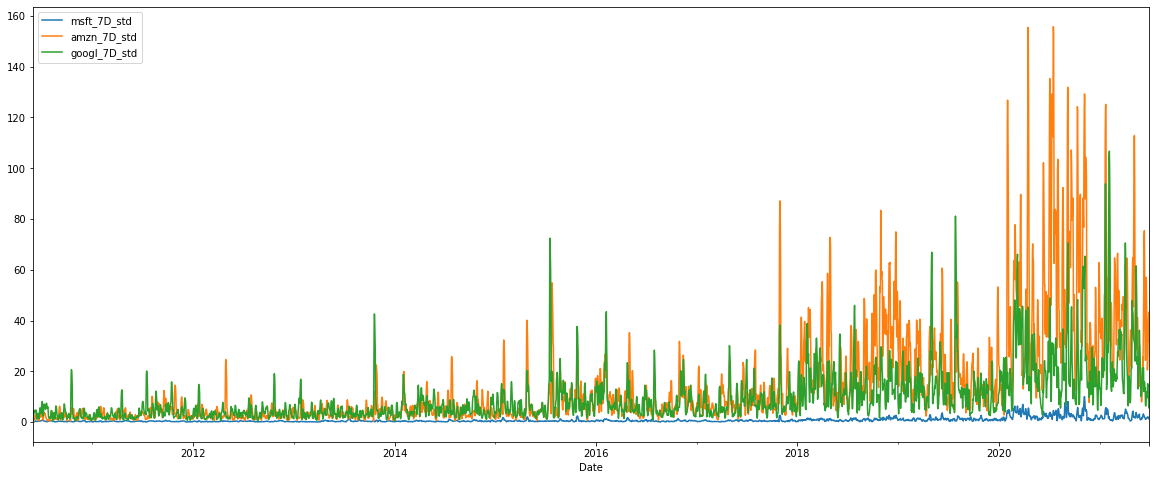

In [10]:
stocks_rolling_stds = get_rolling_stds_dataframe(stocks_dictionary_inferred)
stocks_rolling_stds.plot(figsize=(20,8))

Here we can see that other than microsoft (which also exhibits some minor variability in standard deviation) all of the stock variability changes over time.

<AxesSubplot:xlabel='Date'>

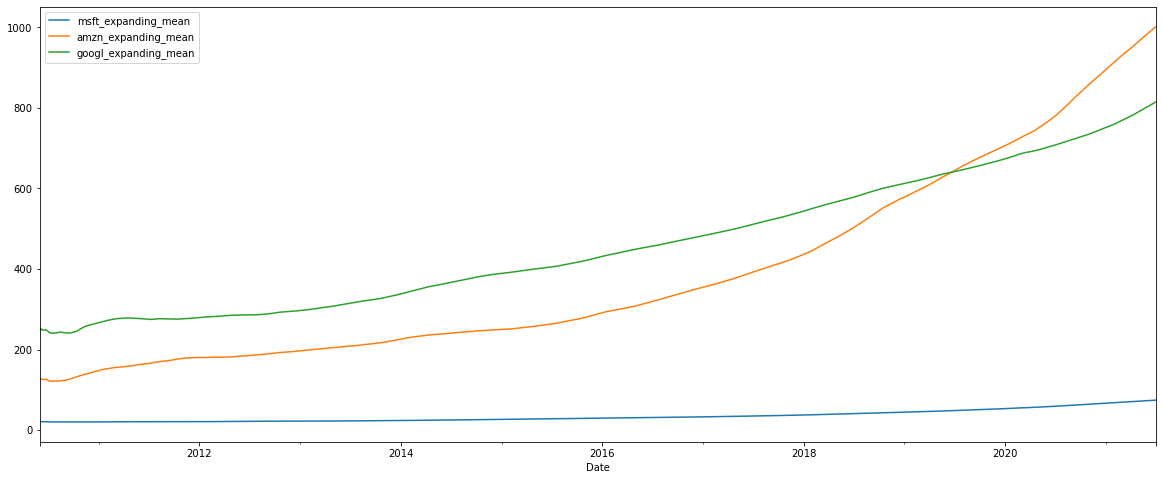

In [11]:
stocks_expanding_means = get_expanding_means_dataframe(stocks_dictionary_inferred)
stocks_expanding_means.plot(figsize=(20,8))

Looking at expanding means, we can clearly see that our observation about trend was valid, even in the case of microsoft, who in last year seems to trend upwards.

<AxesSubplot:xlabel='Date'>

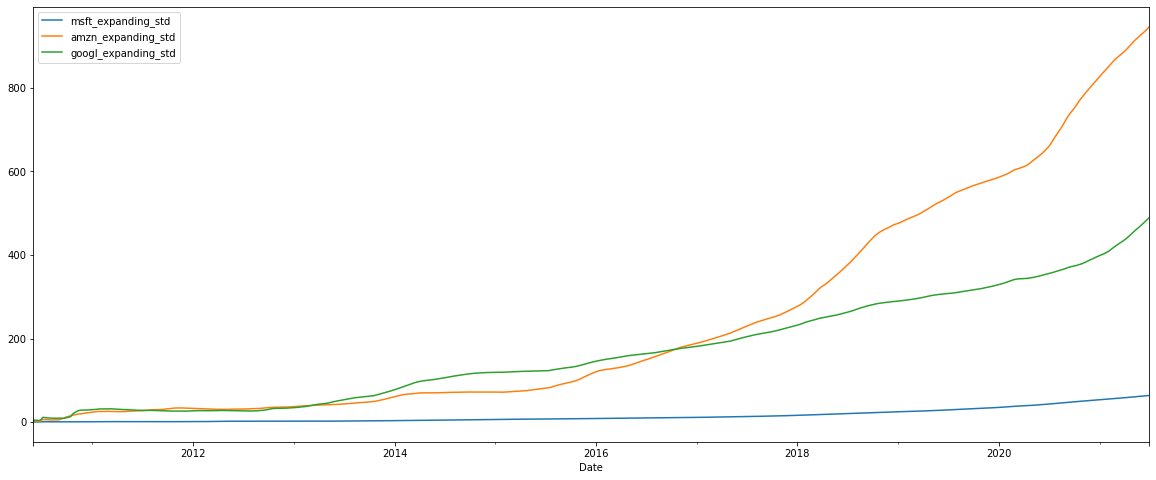

In [12]:
stocks_expanding_stds = get_expanding_stds_dataframe(stocks_dictionary_inferred)
stocks_expanding_stds.plot(figsize=(20,8))

Looking at expanding standard deviations, we can clearly see that our observation about change of variability over time was valid, especially in last two years of observations, even in the case of microsoft, who in last year seems to vary more.

We will need to transform data, to be able to make valid predictions, and fit our models. This is especially true for ARIMA and SARIMA models that are prone to perform poorly on nonstationary data. Also even though NeuralNets and Prophet can deal with those, it won't hurt them in long term to be able to work on better "performing" data. In that regard we will use the following transformations, to handle undesirable properties of data:
- We will try to reduce the variability of data by taking a log of their values. Stock prices are strictly positive, so this change shouldn't affect our predictions at all but will help with changes in standard deviations over time (at least a little bit).
- Rather than trying to model the raw price of a stock, we will focus on the daily percent change of stock values. This should not only help us center the data around 0 and restrict its range to (-1,1) but also help us focus more on the daily and seasonal variability characteristics rather than the underlying trend, which is the result of those changes. We can also think of this change as a simple differentiation operator with additional regularization, to get rid of the trend.
- Lastly, we will normalize the resulting data. This is mostly a cosmetic change but may benefit NeuralNet architectures.

So in summary rather than trying to model raw stock price, we will focus on modeling normalized daily percentage change in the logarithm of stock prices.

In [13]:
value_column = "High"

stocks_dictionary_daily_percent_change = {
    stock: pd.DataFrame(stock_values[value_column].apply(np.log).pct_change(periods=1, axis=0)).rename(columns = {value_column:value_column+"_pct_change"})
    for stock, stock_values in stocks_dictionary_inferred.items()
}

In [14]:
from python_scripts.analytic_functions import determine_normalized_timeseries_data

In [15]:
normalized_stocks_dictionary = determine_normalized_timeseries_data(
    timeseries_data_dictionary = stocks_dictionary_daily_percent_change,
    timeseries_column = "High_pct_change"
)

<AxesSubplot:xlabel='Date'>

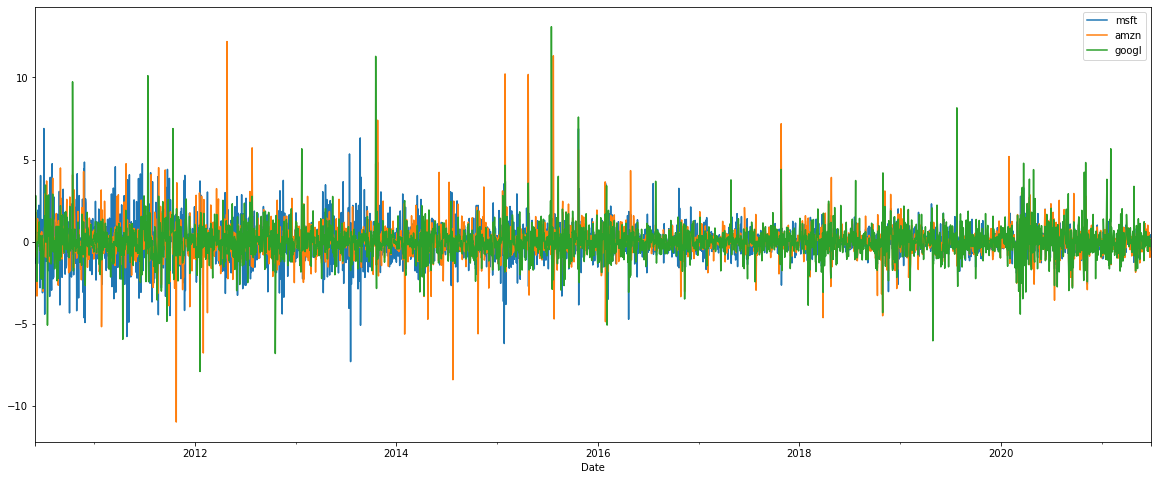

In [16]:
stocks_percent_change = pd.concat(stocks_dictionary_daily_percent_change.values(), axis=1, ignore_index=False)
stocks_percent_change.columns = stocks_dictionary_daily_percent_change.keys()
stocks_percent_change.plot(figsize=(20,8))

In [17]:
normalized_stocks_sataframes_dictionary = {stock: pd.DataFrame(stock_values) for stock, stock_values in normalized_stocks_dictionary.items()}

<AxesSubplot:xlabel='Date'>

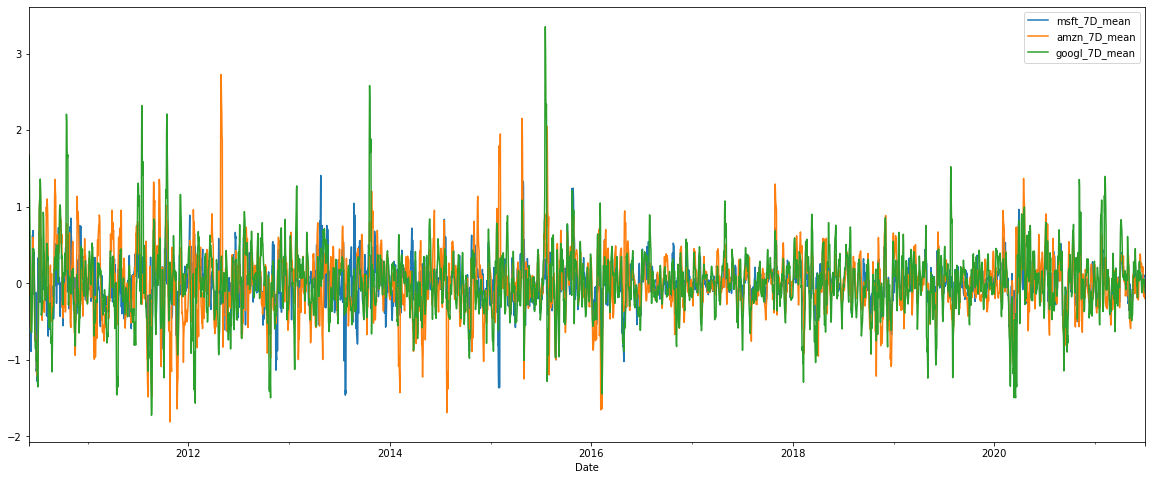

In [18]:
stocks_daily_percent_change_rolling_mean = get_rolling_means_dataframe(normalized_stocks_sataframes_dictionary,value_column="normalized_timeseries")
stocks_daily_percent_change_rolling_mean.plot(figsize=(20,8))

Looking at rolling mean changes over time we can see that other than occasional spikes (outliers in our observations) mean values are now centered around 0, with pretty stable variation, and no visible trend. There may be some seasonality left out there, but on a given plot it is not easly discernable, and especially for NeuralNets not so much of a problem.

<AxesSubplot:xlabel='Date'>

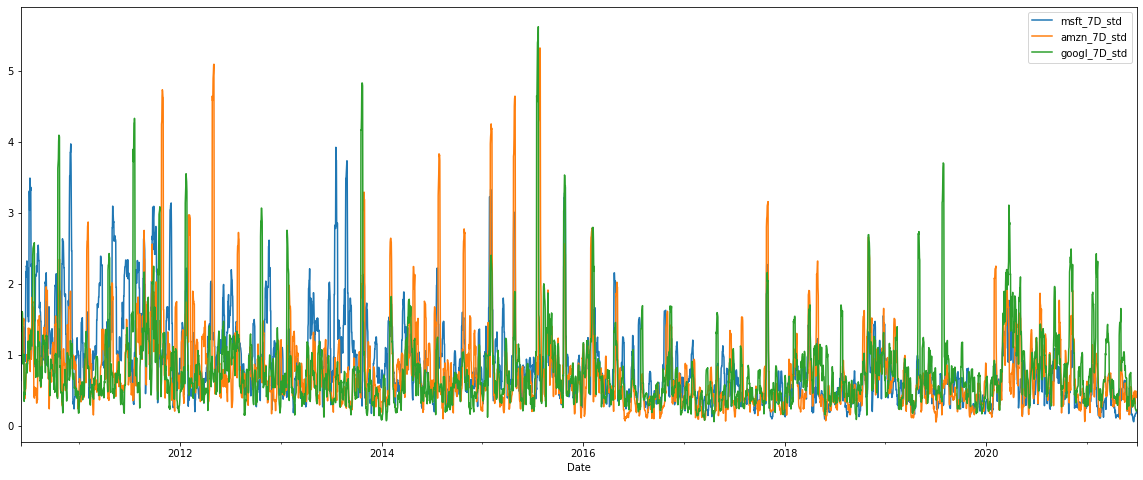

In [19]:
stocks_daily_percent_change_rolling_stds = get_rolling_stds_dataframe(normalized_stocks_sataframes_dictionary,value_column="normalized_timeseries")
stocks_daily_percent_change_rolling_stds.plot(figsize=(20,8))

Looking at rolling stand deviation changes over time we can see that other than occasional spikes (outliers in our observations) variation is quite consistent over the years. We may see some minor change going on for the last four years, as it seems that given stocks became much less volatile, than previously, but in the wider spectrum there doesn't seem to be much of a difference between those and previous years.  There may be some seasonality left out there, but on a given plot it is not easily discernable, and especially for NeuralNets not so much of a problem.

<AxesSubplot:xlabel='Date'>

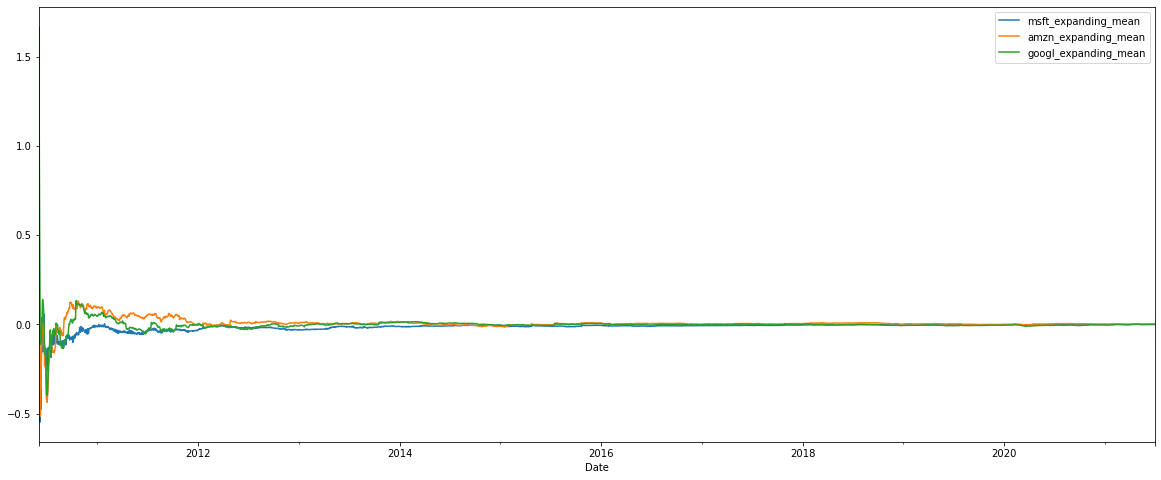

In [20]:
stocks_daily_percent_change_expanding_mean = get_expanding_means_dataframe(normalized_stocks_sataframes_dictionary,value_column="normalized_timeseries")
stocks_daily_percent_change_expanding_mean.plot(figsize=(20,8))

Loking at expanding means, after some initial interval, where we can see some major volatility, due to the small number of observations, our means are now pretty much stable after 2012, without any major variation or trend going on over the years, which again is beneficial to more traditional (ARIMA based) models.

<AxesSubplot:xlabel='Date'>

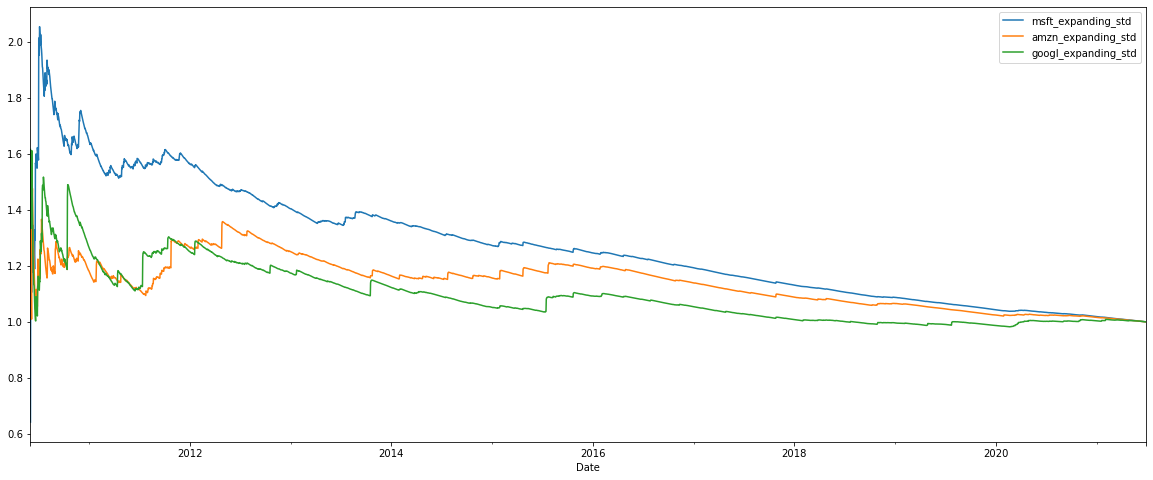

In [21]:
stocks_daily_percent_change_expanding_stds = get_expanding_stds_dataframe(normalized_stocks_sataframes_dictionary,value_column="normalized_timeseries")
stocks_daily_percent_change_expanding_stds.plot(figsize=(20,8))

It is a bit harder to determine whether or not we have a major change in standard deviation going on over the years. The values seem to converge over time to 1.2, after some initial period of fluctuation (due to the lack of observations), but we can see some spikes and variations going on even after 2012. Due to that some further testing normally could be beneficial to us, but we can also see that even those values aren't that far off from the limit. From that, we may assume for that project that also the variation has been stabilized due to our changes. Also, the convergence property nicely complements our previous observation about change in the mean behavior and its volatility over time.

# Time series analysis

Here we will take a bit closer look at derived time series, from the point of ARIMA-based models. We will try to assess whether or not there is an underlying trend (Dickery-Fuller test) as well as take a quick peek (again) at Rolling Means and Std's for our time series. Lastly, we will decide on the range of considerable orders for our models. 

In [22]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib import pyplot as plt

from python_scripts.analytic_functions import dickery_fuller_test

Test Statistic           -28.975892
p-value                    0.000000
Lags Used                  4.000000
Observations Used       4042.000000
Critical Value (1%)       -3.431969
Critical Value (5%)       -2.862255
Critical Value (10%)      -2.567151
dtype: float64


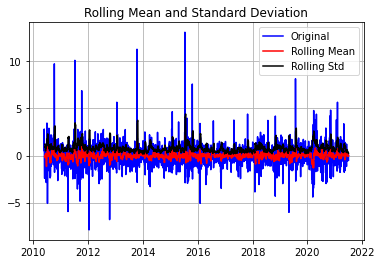

In [23]:
dickery_fuller_test(normalized_stocks_dictionary["googl"])

Test Statistic         -1.248186e+01
p-value                 3.078908e-23
Lags Used               2.800000e+01
Observations Used       4.018000e+03
Critical Value (1%)    -3.431979e+00
Critical Value (5%)    -2.862260e+00
Critical Value (10%)   -2.567153e+00
dtype: float64


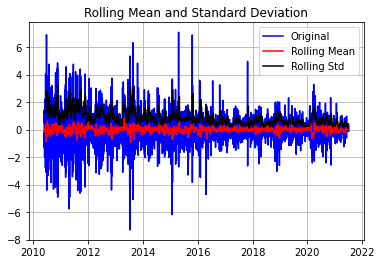

In [24]:
dickery_fuller_test(normalized_stocks_dictionary["msft"])

Test Statistic           -27.207501
p-value                    0.000000
Lags Used                  5.000000
Observations Used       4041.000000
Critical Value (1%)       -3.431969
Critical Value (5%)       -2.862256
Critical Value (10%)      -2.567151
dtype: float64


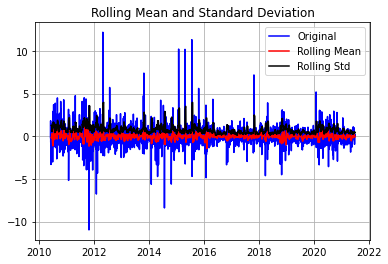

In [25]:
dickery_fuller_test(normalized_stocks_dictionary["amzn"])

*Here we conclude the results of the Dickey-Fuller test, as we are interested in systematic changes to mean values of the time series.*

**H0**: There is a unit root (there is an underlying trend to the data)

**H1**: There is no unit root (there is an underlying trend to the data)

**Conclusion**: Because for all three time series in consideration p_value is much higher than Critical Value at 99% Confidence Interval, we can reject 
Null Hypothesis at alpha = 0.01, meaning that there is no unit root. The series may still be nonstationary, but due to the previous analysis of mean and variance, we can see that it is not the case. We have neither a visible trend nor any significant change in variance after the first year of data, which is visible on the rolling means and standard deviation plots.

It is much harder to test for change in variance, but we can make the following observation:

Suppose that our initial data is denoted as $X_i$. If we define $$Y_i = (X_i - \mu)^2$$ then we may observe that testing for the change of mean for $Y_i$ is equivalent to testing for the change of variance in the case of $X_i$ as 
$$\mathbb{E}Y_i = \mathbb{E}(X_i-\mu)^2=Var(X_i)$$

As we normalized the data, we have $\mu=0$, so we only need to square the remaining time series and apply our test again.

Test Statistic           -32.511112
p-value                    0.000000
Lags Used                  2.000000
Observations Used       4044.000000
Critical Value (1%)       -3.431968
Critical Value (5%)       -2.862255
Critical Value (10%)      -2.567151
dtype: float64


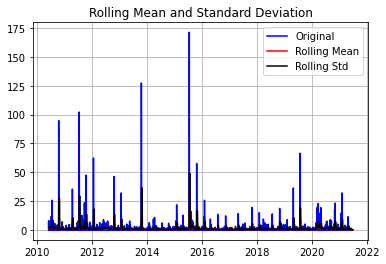

In [26]:
dickery_fuller_test(normalized_stocks_dictionary["googl"]**2)

Test Statistic         -8.522058e+00
p-value                 1.093923e-13
Lags Used               2.800000e+01
Observations Used       4.018000e+03
Critical Value (1%)    -3.431979e+00
Critical Value (5%)    -2.862260e+00
Critical Value (10%)   -2.567153e+00
dtype: float64


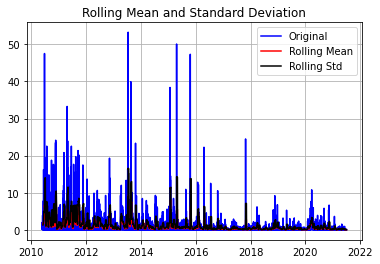

In [27]:
dickery_fuller_test(normalized_stocks_dictionary["msft"]**2)

Test Statistic           -32.820753
p-value                    0.000000
Lags Used                  2.000000
Observations Used       4044.000000
Critical Value (1%)       -3.431968
Critical Value (5%)       -2.862255
Critical Value (10%)      -2.567151
dtype: float64


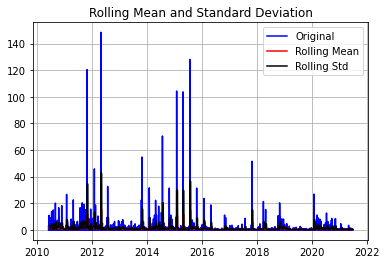

In [28]:
dickery_fuller_test(normalized_stocks_dictionary["amzn"]**2)

*Here we conclude the results of the Dickey-Fuller test, as we are interested in systematic changes to mean values of the time series.*

**H0**: There is a unit root (there is an underlying trend to the data)

**H1**: There is no unit root (there is an underlying trend to the data)

**Conclusion**: Because for all three time series in consideration p_value is much higher than Critical Value at 99% Confidence Interval, we can reject Null Hypothesis at alpha = 0.01, meaning that there is no unit root. This in tandem with the previous test, and our observations about the nature of change of mean, concludes the testing for the stationarity of time series, as with pretty high confidence now we can assess that all of the considered time series are in fact stationary.

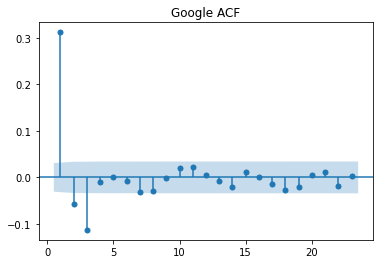

In [29]:
plot_acf(normalized_stocks_dictionary["googl"],lags=range(1,24), alpha=0.05,title="Google ACF")
plt.show()

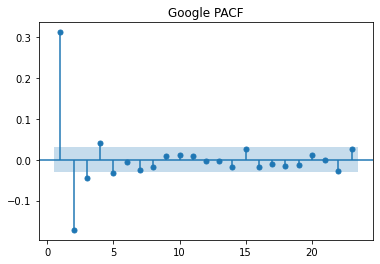

In [30]:
plot_pacf(normalized_stocks_dictionary["googl"],lags=range(1,24), alpha=0.05,title="Google PACF")
plt.show()

Here we can make the following observations based on the ACF plot for *GOOGLE* stocks:
- Values are alternating between positive and negative, decaying to zero, which would imply some kind of autoregressive model. 
This is based on the PACF plot:
- We can see that values are decaying, starting after a few lags. This implies, that we are working with a mixed autoregressive and moving average (ARMA) model.
Based on PACF it could have an AR order of up to 2.

and based on PACF plot for *GOOGLE* stocks:
- Values are alternating positive and negative, decaying to zero, which would imply some kind of moving average model. 
This is based on the ACF plot:
- We can see that values are decaying, starting after a few lags. This implies, that we are working with a mixed autoregressive and moving average (ARMA) model.
Based on the ACF plot it could have an MA order of up to 3

Those observations in turn yeild us in conclusion ARMA class models with p ranging from 1 to 2 and q ranging from 1 to 3.

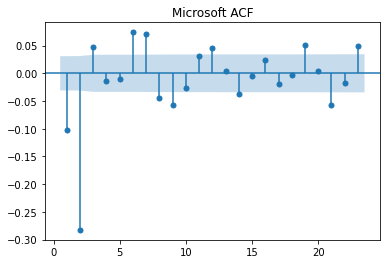

In [31]:
plot_acf(normalized_stocks_dictionary["msft"],lags=range(1,24), alpha=0.05,title="Microsoft ACF")
plt.show()

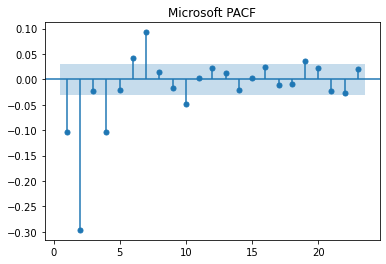

In [32]:
plot_pacf(normalized_stocks_dictionary["msft"],lags=range(1,24), alpha=0.05,title="Microsoft PACF")
plt.show()

Here we can make the following observations based on the ACF plot for *MICROSOFT* stocks:
- Values are alternating between positive and negative, decaying to zero, which would imply some kind of autoregressive model. 
This is based on the PACF plot:
- We can see that values are decaying, starting after a few lags. This implies, that we are working with a mixed autoregressive and moving average (ARMA) model.
Based on PACF it could have an AR order of up to 2.

and based on PACF plot for *MICROSOFT* stocks:
- Values are alternating positive and negative, decaying to zero, which would imply some kind of moving average model. 
This is based on the ACF plot:
- We can see that values are decaying, starting after a few lags. This implies, that we are working with a mixed autoregressive and moving average (ARMA) model.
Based on the ACF plot it could have an MA order of up to 4

We can also see some seasonality in both plots, in effect evry 6 to 10 months

Those observations in turn yield us in conclusion ARMA class models with p ranging from 1 to 2 and q ranging from 1 to 4, and possible seasonality affects every 6 to 10 months.

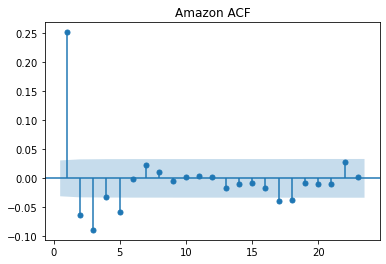

In [33]:
plot_acf(normalized_stocks_dictionary["amzn"],lags=range(1,24), alpha=0.05,title="Amazon ACF")
plt.show()

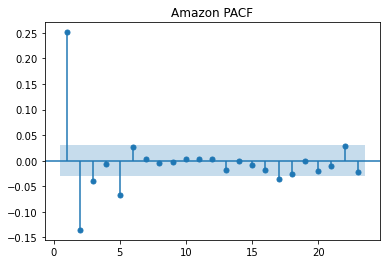

In [34]:
plot_pacf(normalized_stocks_dictionary["amzn"],lags=range(1,24), alpha=0.05,title="Amazon PACF")
plt.show()

Here we can make the following observations based on the ACF plot for *MICROSOFT* stocks:
- Values are alternating between positive and negative, decaying to zero, which would imply some kind of autoregressive model. 
This is based on the PACF plot:
- We can see that values are decaying, starting after a few lags. This implies, that we are working with a mixed autoregressive and moving average (ARMA) model.
Based on PACF it could have an AR order of up to 2.

and based on PACF plot for *MICROSOFT* stocks:
- Values are alternating positive and negative, decaying to zero, which would imply some kind of moving average model. 
This is based on the ACF plot:
- We can see that values are decaying, starting after a few lags. This implies, that we are working with a mixed autoregressive and moving average (ARMA) model.
Based on the ACF plot it could have an MA order of up to 2

We can also see some seasonality in both plots, in effect evry 12 months

Those observations in turn yield us in conclusion ARMA class models with p ranging from 1 to 2 and q ranging from 1 to 2, and possible seasonality affects every 6 to 10 months.

# Modeling

## Prophet

First of we will start with Prophet based models, as they are easiest to fit, and will provide some baseline to our prediction capabilities over raw mean.

In [35]:
from prophet import Prophet

Some data preparation, to accomodate required structure.

In [36]:
microsoft_time_series = normalized_stocks_dictionary["msft"]
microsoft_time_series_testing = microsoft_time_series.last('366D')
microsoft_time_series_training = microsoft_time_series[~microsoft_time_series.index.isin(microsoft_time_series_testing.index)].copy(deep = True)

google_time_series = normalized_stocks_dictionary["googl"]
google_time_series_testing = google_time_series.last('366D')
google_time_series_training = google_time_series[~google_time_series.index.isin(google_time_series_testing.index)].copy(deep = True)

amazon_time_series = normalized_stocks_dictionary["amzn"]
amazon_time_series_testing = amazon_time_series.last('366D')
amazon_time_series_training = amazon_time_series[~amazon_time_series.index.isin(amazon_time_series_testing.index)].copy(deep = True)

In [37]:
microsoft_time_series_testing = microsoft_time_series_testing.reset_index().rename(columns = {'Date':'ds','normalized_timeseries':'y'})
microsoft_time_series_training = microsoft_time_series_training.reset_index().rename(columns = {'Date':'ds','normalized_timeseries':'y'})

google_time_series_testing = google_time_series_testing.reset_index().rename(columns = {'Date':'ds','normalized_timeseries':'y'})
google_time_series_training = google_time_series_training.reset_index().rename(columns = {'Date':'ds','normalized_timeseries':'y'})

amazon_time_series_testing = amazon_time_series_testing.reset_index().rename(columns = {'Date':'ds','normalized_timeseries':'y'})
amazon_time_series_training = amazon_time_series_training.reset_index().rename(columns = {'Date':'ds','normalized_timeseries':'y'})

Model definitions. As we are dealing with US based companies, we can leave many parameters as defaults.

In [38]:
microsoft_prophet = Prophet(daily_seasonality=True)
microsoft_prophet.fit(microsoft_time_series_training)

google_prophet = Prophet(daily_seasonality=True)
google_prophet.fit(google_time_series_training)

amazon_prophet = Prophet(daily_seasonality=True)
amazon_prophet.fit(amazon_time_series_training)

Initial log joint probability = -47.4409
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5357.62   0.000675695       125.546      0.6698      0.6698      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     112       5358.21    0.00035737       193.698   3.125e-06       0.001      172  LS failed, Hessian reset 
     180       5359.19    0.00133949       335.898   1.099e-05       0.001      284  LS failed, Hessian reset 
     199       5359.38   7.11183e-05       92.6399           1           1      308   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     242       5359.47   6.13256e-08       97.2175      0.1035      0.3407      362   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -13.5331
    Iter      log prob        ||dx||      ||grad||   

In [142]:
joblib_dump(microsoft_prophet, "models/microsoft/microsoft_prophet.joblib", compress = ("gzip",5), protocol = 3)
joblib_dump(google_prophet, "models/google/google_prophet.joblib", compress = ("gzip",5), protocol = 3)
joblib_dump(amazon_prophet, "models/amazon/amazon_prophet.joblib", compress = ("gzip",5), protocol = 3)

['models/amazon/amazon_prophet.joblib']

Here we make predictions for our unseen set.

In [39]:
microsoft_future = microsoft_prophet.make_future_dataframe(periods=366)
google_future = google_prophet.make_future_dataframe(periods=366)
amazon_future = amazon_prophet.make_future_dataframe(periods=366)

In [40]:
google_forecast = google_prophet.predict(google_future)
microsoft_forecast = microsoft_prophet.predict(microsoft_future)
amazon_forecast = amazon_prophet.predict(amazon_future)

In [41]:
forecast_columns = ['ds', 'yhat', 'yhat_lower', 'yhat_upper']

In [42]:
google_fit = google_forecast[forecast_columns].merge(google_time_series_training, left_on = 'ds', right_on = 'ds').set_index('ds')
microsoft_fit = microsoft_forecast[forecast_columns].merge(microsoft_time_series_training, left_on = 'ds', right_on = 'ds').set_index('ds')
amazon_fit = amazon_forecast[forecast_columns].merge(amazon_time_series_training, left_on = 'ds', right_on = 'ds').set_index('ds')

Here we may plot our predictions against observed values for the seen period of time:

<AxesSubplot:xlabel='ds'>

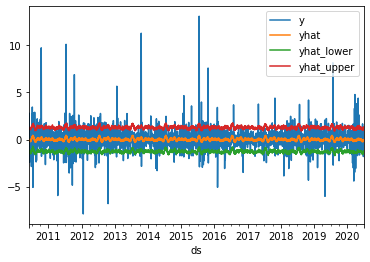

In [43]:
google_fit[['y','yhat','yhat_lower','yhat_upper']].plot()

<AxesSubplot:xlabel='ds'>

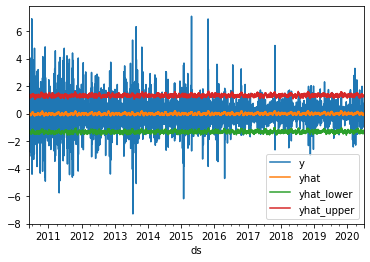

In [44]:
microsoft_fit[['y','yhat','yhat_lower','yhat_upper']].plot()

<AxesSubplot:xlabel='ds'>

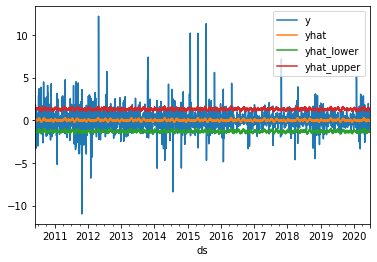

In [45]:
amazon_fit[['y','yhat','yhat_lower','yhat_upper']].plot()

As well against unseen:

In [46]:
google_forecast_frame = google_forecast[forecast_columns].merge(google_time_series_testing, left_on = 'ds', right_on = 'ds').set_index('ds')
microsoft_forecast_frame = microsoft_forecast[forecast_columns].merge(microsoft_time_series_testing, left_on = 'ds', right_on = 'ds').set_index('ds')
amazon_forecast_frame = amazon_forecast[forecast_columns].merge(amazon_time_series_testing, left_on = 'ds', right_on = 'ds').set_index('ds')

<AxesSubplot:xlabel='ds'>

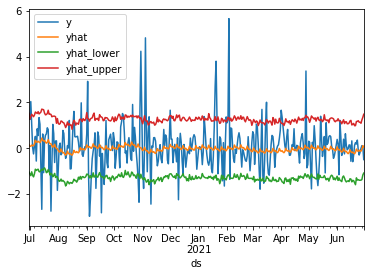

In [47]:
google_forecast_frame[['y','yhat','yhat_lower','yhat_upper']].plot()

<AxesSubplot:xlabel='ds'>

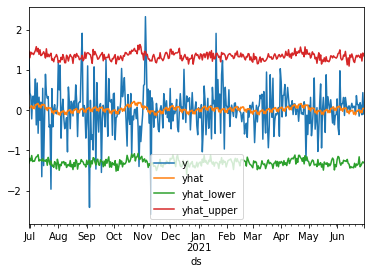

In [48]:
microsoft_forecast_frame[['y','yhat','yhat_lower','yhat_upper']].plot()

<AxesSubplot:xlabel='ds'>

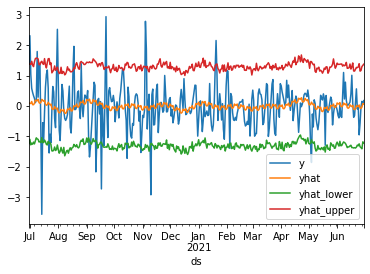

In [49]:
amazon_forecast_frame[['y','yhat','yhat_lower','yhat_upper']].plot()

We can see that in both cases for either of the companies Prophet was able to extract some variation, as well as seasonality coefficient. Despite that, even though other than some outliers, observations are in the confidence bounds, we can say for sure, that model underfits the variability of observed data, vastly underestimating its scope. This in turn leads to very weak point predictions, and as a whole model is not that good for our task.

We can also take a look at some of the extracted seasonality and trend components.

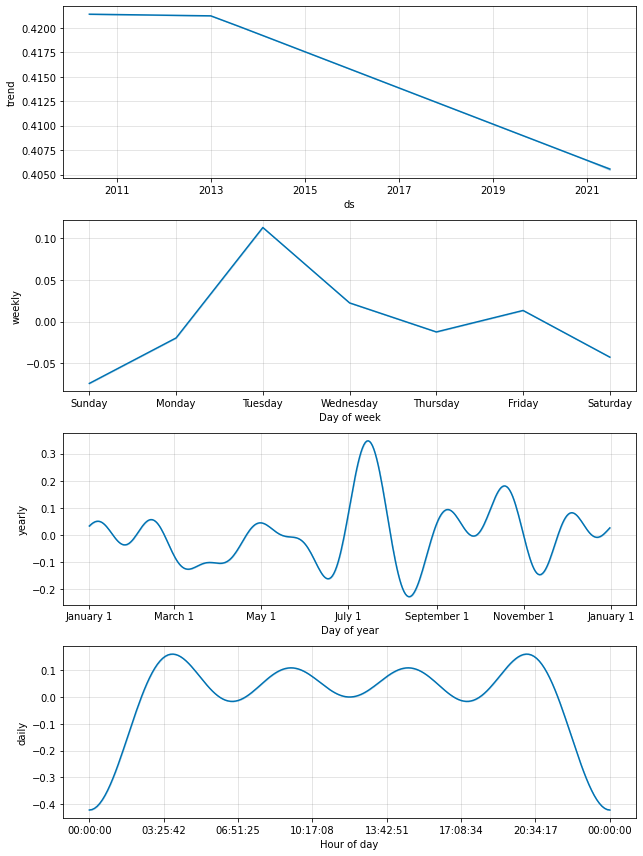

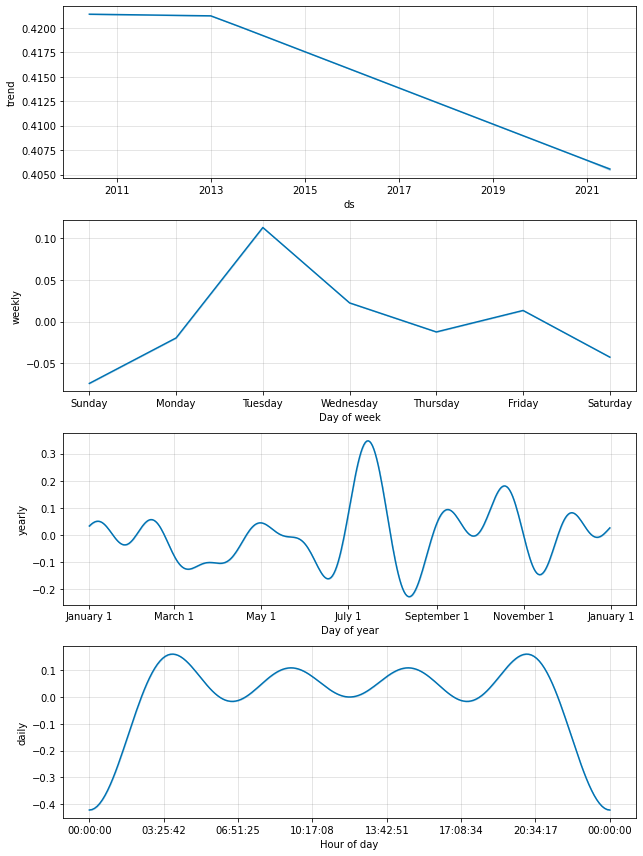

In [50]:
google_prophet.plot_components(google_forecast)

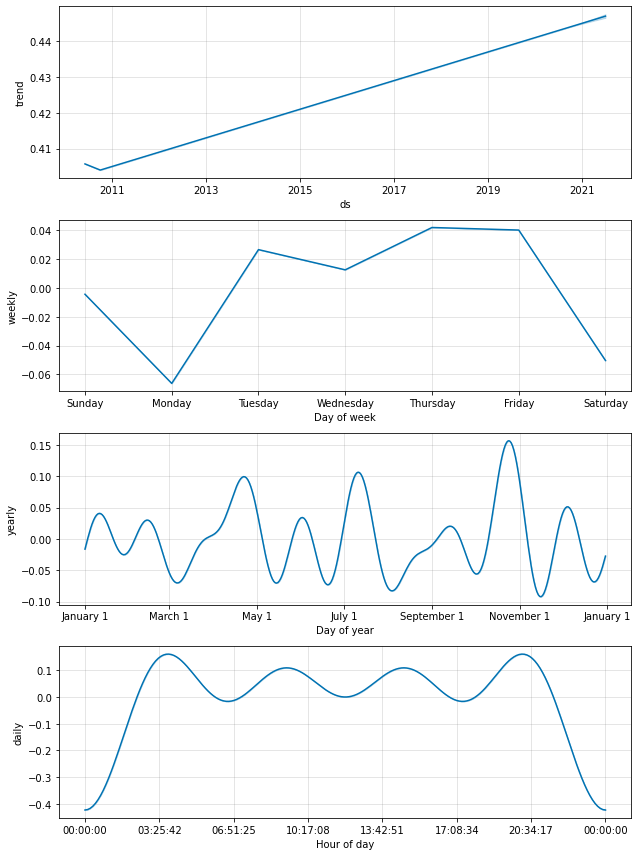

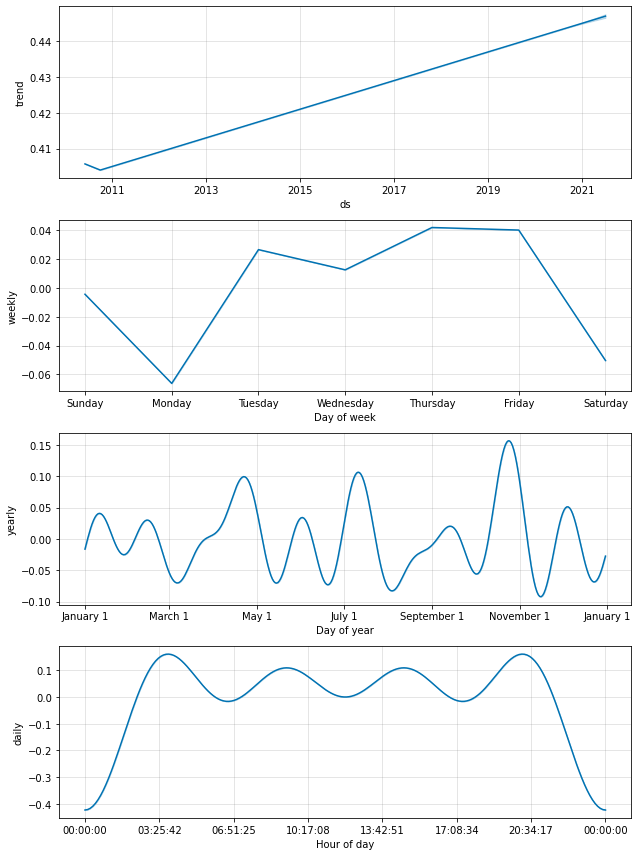

In [51]:
microsoft_prophet.plot_components(microsoft_forecast)

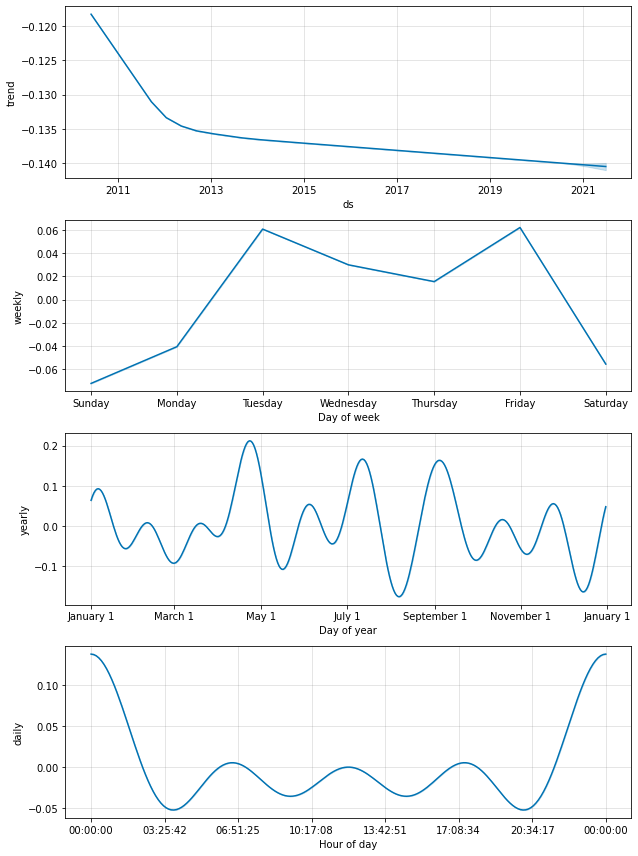

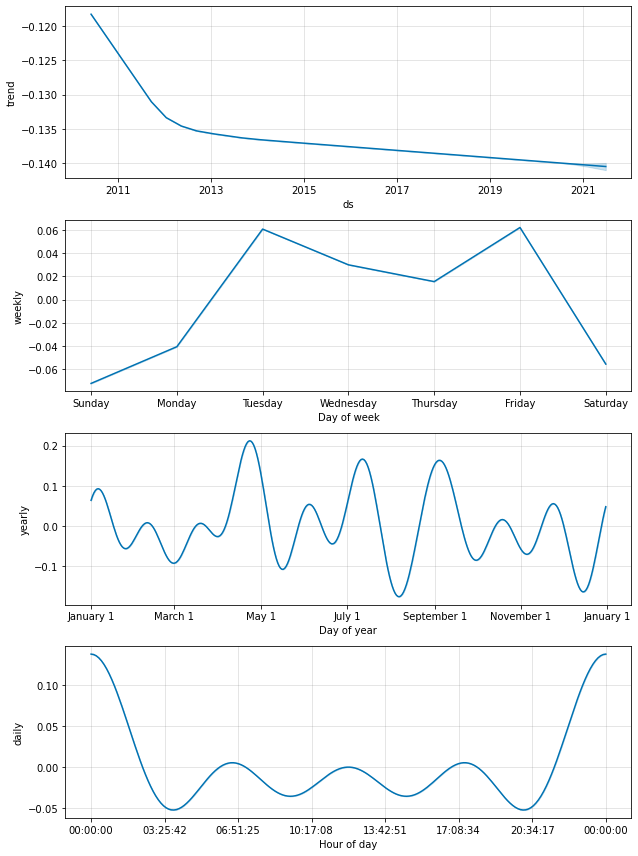

In [52]:
amazon_prophet.plot_components(amazon_forecast)

We can see that we did quite a good job with removing both trend and variability in variance from timseries, but some underlying trend structure is clearly present in all of the series, especially in case of Amazon and Microsoft.

Finally we can look at our error statistics:

In [53]:
print(f"Google MSE: {mse(y_true = google_forecast_frame.y, y_pred = google_forecast_frame.yhat)}")

Google MSE: 0.9869636128948577


In [54]:
print(f"Microsoft MSE: {mse(y_true = microsoft_forecast_frame.y, y_pred = microsoft_forecast_frame.yhat)}")

Microsoft MSE: 0.3146159089969233


In [55]:
print(f"Amazon MSE: {mse(y_true = amazon_forecast_frame.y, y_pred = amazon_forecast_frame.yhat)}")

Amazon MSE: 0.5572029692669923


## Recurrent neural networks

Here we will explore capabilities of NeuralNet architectures, to capture variability and properties of time series.

Beforehand we have quite a few obstacles to clear:
- It is quite hard to extract proper features from RAW time series, in a way that NeuralNet can efficiently analyze.
- Special care needs to be taken while creating training and testing sets, to assess to NeuralNet understandable format.
- We need to take additional care to balance the architecture, both to not let it learn nothing (underfit) or overfit to the data.
- Lastly, we will need to create predictions, which will require some tinkering with the model.

In [56]:
import pandas as pd
pd.set_option('display.max_rows', 128)

import numpy as np
import tensorflow as tf

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

from tensorflow import feature_column
from tensorflow.keras import layers
from keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50

2021-10-18 10:44:06.600762: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-18 10:44:06.616982: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-18 10:44:06.640715: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-18 10:44:06.641192: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [57]:
import tensorflow.compat.v1.keras.backend as tfback

print("tf.__version__ is", tf.__version__)
print("tf.keras.__version__ is:", tf.keras.__version__)

def _get_available_gpus():
    """Get a list of available gpu devices (formatted as strings).

    # Returns
        A list of available GPU devices.
    """
    #global _LOCAL_DEVICES
    if tfback._LOCAL_DEVICES is None:
        devices = tf.config.list_logical_devices()
        tfback._LOCAL_DEVICES = [x.name for x in devices]
    return [x for x in tfback._LOCAL_DEVICES if 'device:gpu' in x.lower()]

tfback._get_available_gpus = _get_available_gpus

tf.__version__ is 2.6.0
tf.keras.__version__ is: 2.6.0


Here function code will be explicitly shown, as it enables the reader to easier track what is done.

First, we will define windowed datasets, on which we will train our data. Essentially what we will do, is to split the dataset into batches of sets of N observations + 1, where based on the first N observations we try to predict N+1 observation. Additionally, some shuffling will be made, to ease the possibility of overfitting, as want to be partially independent of the time when the predictions will be made.

In [58]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

Here we define how we make predictions. So we take windows_size observations and as previously we try to predict the next one.

In [59]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(window_size).prefetch(1)
    forecast = model.predict(ds)
    return forecast

Here we can take a glance at the feature engineering part. In essence, we use parts of the architecture inspired by the original inception and residual modules, used in image recognition neural networks, to be able to extract features from our time series. Other than that we will use two layers of LSTM to be able to analyze subsequently extracted features of the time series.

In [60]:
# function for creating an identity or projection residual module
def residual_module(layer_in, n_filters):
    merge_input = layer_in
    # check if the number of filters needs to be increase, assumes channels last format
    if layer_in.shape[-1] != n_filters:
    merge_input = tf.keras.layers.Conv1D(n_filters, 1, padding='same', activation='tanh', kernel_initializer='he_normal')(layer_in)
    # conv1
    conv1 = tf.keras.layers.Conv1D(n_filters, 3, padding='same', activation='tanh', kernel_initializer='he_normal')(layer_in)
    # conv2
    conv2 = tf.keras.layers.Conv1D(n_filters, 3, padding='same', activation='linear', kernel_initializer='he_normal')(conv1)
    # add filters, assumes filters/channels last
    layer_out = tf.keras.layers.add([conv2, merge_input])
    # activation function
    layer_out = tf.keras.layers.Activation('relu')(layer_out)
    return layer_out

In [62]:
# function for creating an inception inspired module
def inception_like_module(
    layer_in, 
    filters_1 = 128, filters_2 = 128, filters_3 = 192, filters_2_out = 32, filters_3_out = 96, filters_4_out = 64
):
    # conv 1x1
    conv1 = tf.keras.layers.Conv1D(
        filters = filters_1, 
        kernel_size = 1, 
        padding='same',
        activation='tanh',
        kernel_initializer='he_normal'
    )(layer_in)
    # conv 3x3
    conv3 = tf.keras.layers.Conv1D(
        filters = filters_2, 
        kernel_size = 1, 
        padding='same',
        activation='tanh',
        kernel_initializer='he_normal'
    )(layer_in)
    conv3 = tf.keras.layers.Conv1D(
        filters = filters_2_out, 
        kernel_size = 3, 
        padding='same',
        activation='tanh',
        kernel_initializer='he_normal'
    )(conv3)
    # conv 5x5
    conv5 = tf.keras.layers.Conv1D(
        filters = filters_3, 
        kernel_size = 1, 
        padding='same',
        activation='tanh',
        kernel_initializer='he_normal'
    )(layer_in)
    conv5 = tf.keras.layers.Conv1D(
        filters = filters_3_out, 
        kernel_size = 5, 
        padding='same',
        activation='tanh',
        kernel_initializer='he_normal'
    )(layer_in)
    # max pooling 3x3
    pool3 = tf.keras.layers.MaxPooling1D(3, strides=1, padding='same')(layer_in)
    pool3 = tf.keras.layers.Conv1D(
        filters = filters_4_out, 
        kernel_size = 1, 
        padding='same',
        activation='tanh',
        kernel_initializer='he_normal'
    )(pool3)
    # add filters, assumes filters/channels last
    layer_out = tf.keras.layers.concatenate([conv1, conv3, conv5, pool3], axis = -1)
    return layer_out

In [63]:
# function for creating stem part of inception V3
def stem_like_module(
    layer_in
):
    stem = tf.keras.layers.Conv1D(
        filters = 32, 
        kernel_size = 3, 
        strides = 1,
        padding='same',
        activation='tanh',
        kernel_initializer='he_normal'
    )(layer_in)
    
    stem = tf.keras.layers.Conv1D(
        filters = 32, 
        kernel_size = 3, 
        strides = 1,
        padding='same',
        activation='tanh',
        kernel_initializer='he_normal'
    )(stem)
    
    stem = tf.keras.layers.Conv1D(
        filters = 64, 
        kernel_size = 3, 
        strides = 1,
        padding='same',
        activation='tanh',
        kernel_initializer='he_normal'
    )(stem)
    
    stem = tf.keras.layers.MaxPooling1D(3, strides=1, padding='same')(stem)
    
    stem = tf.keras.layers.Conv1D(
        filters = 80, 
        kernel_size = 1, 
        strides = 1,
        padding='same',
        activation='tanh',
        kernel_initializer='he_normal'
    )(stem)
    
    stem = tf.keras.layers.Conv1D(
        filters = 192, 
        kernel_size = 3, 
        strides = 1,
        padding='same',
        activation='tanh',
        kernel_initializer='he_normal'
    )(stem)
    
    stem = tf.keras.layers.Conv1D(
        filters = 256, 
        kernel_size = 3, 
        strides = 1,
        padding='same',
        activation='tanh',
        kernel_initializer='he_normal'
    )(stem)
    
    return stem

In [64]:
def initialize_network(
    window_size,
    n_features,
    network_type = "LSTM",
    module_type = "residual"
):
    input_series = tf.keras.layers.Input((window_size,n_features), name = 'input_series')
    
    if module_type == "residual":
        residual_module_1 = residual_module(input_series, 128)
        pooling_1 = tf.keras.layers.MaxPooling1D(5, strides=1, padding='same')(residual_module_1)
        #droput_1 = tf.keras.layers.Dropout(0.1)(pooling_1)
    
        residual_module_2 = residual_module(pooling_1, 128)   
        pooling_2 = tf.keras.layers.MaxPooling1D(5, strides=1, padding='same')(residual_module_2)
        #droput_2 = tf.keras.layers.Dropout(0.1)(pooling_2)
        
        residual_module_2 = residual_module(pooling_1, 64)   
        pooling_out = tf.keras.layers.MaxPooling1D(3, strides=1, padding='same')(residual_module_2)
        #droput_2 = tf.keras.layers.Dropout(0.1)(pooling_2)
    elif module_type == "inception":
        
        stem_module = stem_like_module(
            layer_in = input_series
        )
        
        inception_module_1 = inception_like_module(stem_module, 64, 96, 128, 16, 32, 32)
        inception_module_2 = inception_like_module(inception_module_1, 128, 128, 192, 32, 96, 64)
        inception_module_3 = inception_like_module(inception_module_2, 64, 96, 128, 16, 32, 32)
        #droput_2 = tf.keras.layers.Dropout(0.1)(pooling_2)
        pooling_out = tf.keras.layers.MaxPooling1D(5, strides=1, padding='same')(inception_module_3)
    
    if network_type == 'LSTM':
        LSTM_1 = tf.keras.layers.LSTM(128, return_sequences=True)(pooling_out)
        pooling_3 = tf.keras.layers.MaxPooling1D(5, strides=1, padding='same')(LSTM_1)
        LSTM_2 = tf.keras.layers.LSTM(64, return_sequences=True)(pooling_3)
        
    if network_type == 'GRU':
        LSTM_1 = tf.keras.layers.GRU(128, return_sequences=True)(pooling_out)
        pooling_3 = tf.keras.layers.MaxPooling1D(5, strides=1, padding='same')(LSTM_1)
        LSTM_2 = tf.keras.layers.GRU(64, return_sequences=True)(pooling_3)
        
    #model = tf.keras.layers.Dropout(0.1)(LSTM_2)
    #model = tf.keras.layers.Dense(32, activation="tanh")(model)
    #model = tf.keras.layers.Dropout(0.1)(model)
    #model = tf.keras.layers.Dense(16, activation="tanh")(model)
    model = tf.keras.layers.Dense(1)(LSTM_2)
    
    return tf.keras.models.Model(inputs = [input_series], outputs = model)

We will use LSTM architecture, as the previous (unaccounted here) experiments have shown that it performs better, with marginally longer training times than GRU.

In [65]:
window_size = 32

LSTM_network = initialize_network(
    window_size = window_size,
    n_features = 1,
    network_type = "LSTM",
    module_type = "inception"
)

2021-10-18 10:44:39.957210: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-18 10:44:39.957668: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-18 10:44:39.957914: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-18 10:44:39.958382: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-18 10:44:39.958639: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Here we can take a look at the whole NN architecture used in the scope of this project. 

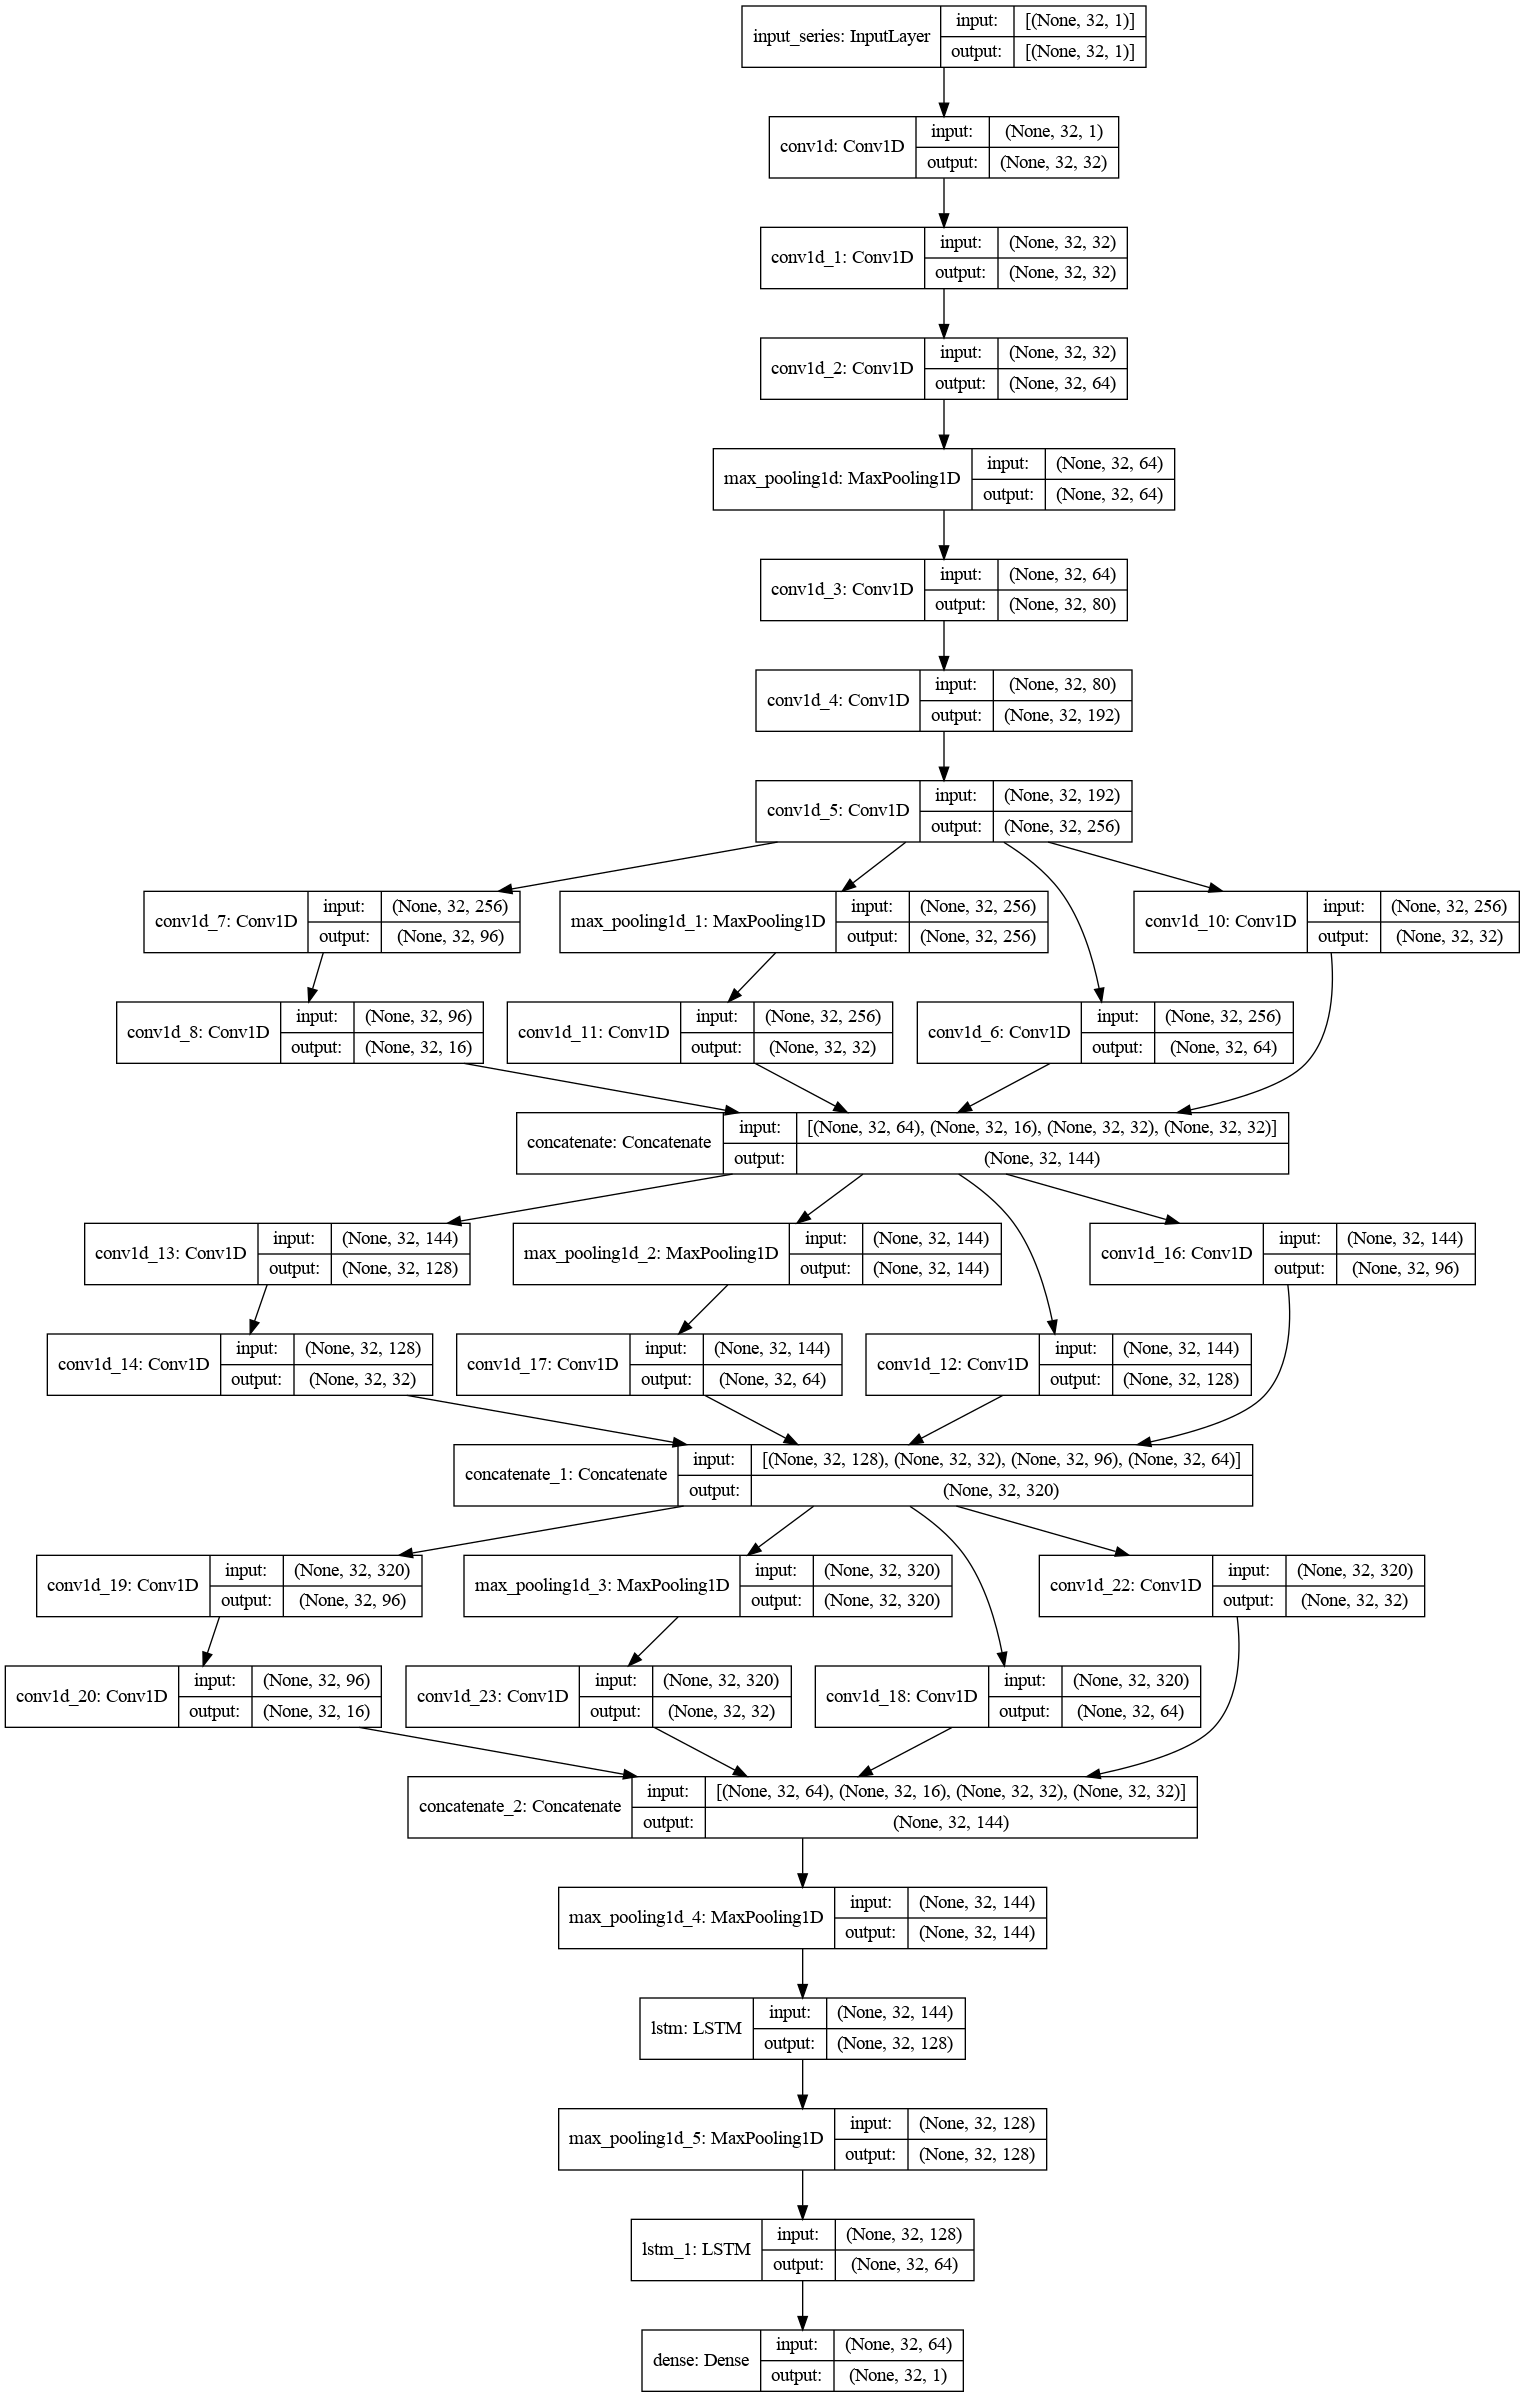

In [66]:
tf.keras.utils.plot_model(LSTM_network, show_shapes=True, show_layer_names=True)

Here we split our dataset to account for the assumptions made at the begining of the project.

In [67]:
split_time = 3681 # year before end

microsoft_series = microsoft_time_series.values
microsoft_time_series_training_lstm = microsoft_series[:split_time]
microsoft_time_series_testing_lstm = microsoft_series[split_time:]

google_series = google_time_series.values
google_time_series_training_lstm = google_series[:split_time]
google_time_series_testing_lstm = google_series[split_time:]

amazon_series = amazon_time_series.values
amazon_time_series_training_lstm = amazon_series[:split_time]
amazon_time_series_testing_lstm = amazon_series[split_time:]

time = microsoft_time_series.index.values
time_training = time[:split_time]
time_testing = time[split_time:]

And define both training sets, as well as the other parameters of our initial run of the Neural Network parameters selection. Here we will try to optimize the epsilon for training, by monitoring the given loss. The idea is to find the highest epsilon for which the training is still stable (we don't see fluctuations in subsequent losses).

### Microsoft

In [69]:
tf.keras.backend.clear_session()
tf.random.set_seed(95147)
np.random.seed(95147)
window_size = 32
batch_size = 128
shuffle_buffer_size = 1024
train_set = windowed_dataset(microsoft_time_series_training_lstm, window_size, batch_size, shuffle_buffer_size)

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-6)

LSTM_network = initialize_network(
    window_size = window_size,
    n_features = 1,
    network_type = "LSTM",
    module_type = "inception"
)

LSTM_network.compile(
    loss=tf.keras.losses.Huber(),
    optimizer=optimizer,
    metrics=["mse"])

In [70]:
history = LSTM_network.fit(train_set, epochs=100, callbacks=[lr_schedule])

2021-10-13 08:15:23.384429: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2021-10-13 08:15:27.592238: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8101
2021-10-13 08:15:29.206462: W tensorflow/core/common_runtime/bfc_allocator.cc:338] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.
2021-10-13 08:15:29.844177: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


29/29 [==============================] - 9s 62ms/step - loss: 0.3614 - mse: 1.0746
Epoch 2/100
29/29 [==============================] - 1s 26ms/step - loss: 0.3591 - mse: 1.0687
Epoch 3/100
29/29 [==============================] - 1s 26ms/step - loss: 0.3571 - mse: 1.0637
Epoch 4/100
29/29 [==============================] - 1s 26ms/step - loss: 0.3554 - mse: 1.0596
Epoch 5/100
29/29 [==============================] - 1s 26ms/step - loss: 0.3539 - mse: 1.0558
Epoch 6/100
29/29 [==============================] - 1s 27ms/step - loss: 0.3524 - mse: 1.0523
Epoch 7/100
29/29 [==============================] - 1s 27ms/step - loss: 0.3510 - mse: 1.0490
Epoch 8/100
29/29 [==============================] - 1s 27ms/step - loss: 0.3498 - mse: 1.0460
Epoch 9/100
29/29 [==============================] - 1s 27ms/step - loss: 0.3485 - mse: 1.0430
Epoch 10/100
29/29 [==============================] - 1s 26ms/step - loss: 0.3473 - mse: 1.0403
Epoch 11/100
29/29 [==============================] - 1s 26ms

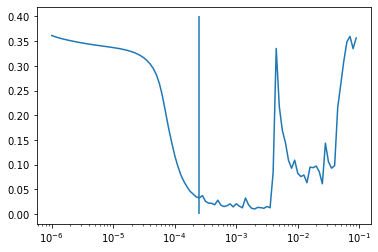

In [120]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.vlines(2.5*1e-4,0,0.4)

Here we can see that around $5*1e-4$ loss levels down, and learning rate starts to vary slightly, until it reaches $5*1e-2$ where it skyrockets.

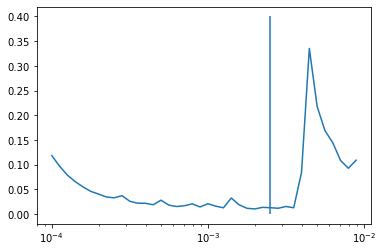

In [119]:
plt.semilogx(history.history["lr"][40:80], history.history["loss"][40:80])
plt.vlines(2.5*1e-3,0,0.4)

Given sligthly higher variation after $1e-3$ we will pick as our learning rate value of $2.5*1e-3$

In [69]:
tf.keras.backend.clear_session()
tf.random.set_seed(95147)
np.random.seed(95147)
window_size = 64
batch_size = 128
shuffle_buffer_size = 1024
train_set = windowed_dataset(microsoft_time_series_training_lstm, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(microsoft_time_series_training_lstm.shape)
test_set = windowed_dataset(microsoft_time_series_testing_lstm, window_size, batch_size, shuffle_buffer_size)
print(test_set)
print(microsoft_time_series_testing_lstm.shape)

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3681,)
<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(366,)


Here we bergin the training. As the early stopping has been allowed, by monitoring change over validation set, we don't need to worry much about overfiting to the training data. The criterion for stoping is that for 10 subsequent iterations loss function over validation set doesn't improve more than $1e-4$.

In [ ]:
microsoft_mse_list = []

for _ in range(50):
    train_set = windowed_dataset(microsoft_time_series_training_lstm, window_size, batch_size, shuffle_buffer_size)
    test_set = windowed_dataset(microsoft_time_series_testing_lstm, window_size, batch_size, shuffle_buffer_size)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=3*1e-3)

    LSTM_network = initialize_network(
        window_size = window_size,
        n_features = 1,
        network_type = "LSTM",
        module_type = "inception"
    )

    LSTM_network.compile(
        loss=tf.keras.losses.Huber(),
        optimizer=optimizer,
        metrics=["mse"])

    callback = tf.keras.callbacks.EarlyStopping(
        monitor="val_mse",
        min_delta=0.0001,
        patience=10,
        verbose=0,
        mode="auto",
        baseline=None,
        restore_best_weights=True,
    )


    LSTM_history = LSTM_network.fit(train_set,validation_data = test_set, epochs=600, callbacks = [callback])

    LSTM_forecast = model_forecast(LSTM_network, microsoft_series[..., np.newaxis], window_size)
    LSTM_forecast = LSTM_forecast[split_time - window_size:-1, -1, 0]

    microsoft_mse_list.append(mse(microsoft_time_series_testing_lstm,LSTM_forecast))

Due to the shuffling, as well as stochastic properties of gradient descent, the need to properly assess model accuracy arises. For that reason, given architecture has been retrained 50 times, and each time we have gathered information about MSE on the test dataset. Down the line we will use mean value of those, as a way to assess 

In [70]:
microsoft_train_set = windowed_dataset(microsoft_time_series_training_lstm, window_size, batch_size, shuffle_buffer_size)
microsoft_test_set = windowed_dataset(microsoft_time_series_testing_lstm, window_size, batch_size, shuffle_buffer_size)
    
optimizer = tf.keras.optimizers.Adam(learning_rate=3*1e-3)

micrososft_LSTM_network = initialize_network(
    window_size = window_size,
    n_features = 1,
    network_type = "LSTM",
    module_type = "inception"
)

micrososft_LSTM_network.compile(
        loss=tf.keras.losses.Huber(),
        optimizer=optimizer,
        metrics=["mse"])

callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_mse",
    min_delta=0.0001,
    patience=10,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)


microsoft_LSTM_history = micrososft_LSTM_network.fit(
    microsoft_train_set,
    validation_data = microsoft_test_set, 
    epochs=600, 
    callbacks = [callback]
)

microsoft_LSTM_forecast = model_forecast(
    micrososft_LSTM_network, 
    microsoft_series[..., np.newaxis], 
    window_size
)

microsoft_LSTM_forecast = microsoft_LSTM_forecast[split_time - window_size:-1, -1, 0]

2021-10-18 10:45:10.187927: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/600


2021-10-18 10:45:14.573638: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8101
2021-10-18 10:45:16.406940: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.19GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021-10-18 10:45:16.406997: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.19GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021-10-18 10:45:16.706807: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.01GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory

     27/Unknown - 10s 35ms/step - loss: 0.3981 - mse: 1.1978

2021-10-18 10:45:21.134315: W tensorflow/core/common_runtime/bfc_allocator.cc:338] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.


29/29 [==============================] - 12s 139ms/step - loss: 0.3920 - mse: 1.1745 - val_loss: 0.1381 - val_mse: 0.3069
Epoch 2/600
29/29 [==============================] - 2s 44ms/step - loss: 0.3554 - mse: 1.0562 - val_loss: 0.1381 - val_mse: 0.3070
Epoch 3/600
29/29 [==============================] - 2s 45ms/step - loss: 0.3549 - mse: 1.0553 - val_loss: 0.1352 - val_mse: 0.3004
Epoch 4/600
29/29 [==============================] - 2s 42ms/step - loss: 0.3460 - mse: 1.0328 - val_loss: 0.1274 - val_mse: 0.2753
Epoch 5/600
29/29 [==============================] - 2s 42ms/step - loss: 0.3274 - mse: 0.9820 - val_loss: 0.1141 - val_mse: 0.2460
Epoch 6/600
29/29 [==============================] - 2s 43ms/step - loss: 0.3168 - mse: 0.9468 - val_loss: 0.1051 - val_mse: 0.2257
Epoch 7/600
29/29 [==============================] - 2s 42ms/step - loss: 0.2776 - mse: 0.8196 - val_loss: 0.0833 - val_mse: 0.1766
Epoch 8/600
29/29 [==============================] - 2s 42ms/step - loss: 0.2262 - mse

In [143]:
micrososft_LSTM_network.save_weights("models/microsoft/micrososft_LSTM_network_weights")

In [173]:
np.save("microsoft_testing_mse_for_lstm", np.array(microsoft_mse_list))

In [77]:
microsoft_mse_list = np.load("microsoft_testing_mse_for_lstm.npy")

As we can see, we in fact end the training early, after only 60 epochs. Now we can take a peak at how our training and validation loss changed over the epochs.

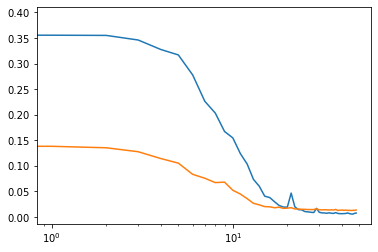

In [71]:
plt.semilogx(range(len(microsoft_LSTM_history.history["loss"])), microsoft_LSTM_history.history["loss"])
plt.semilogx(range(len(microsoft_LSTM_history.history["val_loss"])), microsoft_LSTM_history.history["val_loss"])

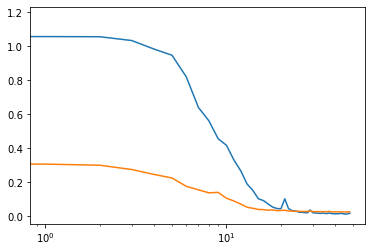

In [72]:
plt.semilogx(range(len(microsoft_LSTM_history.history["mse"])), microsoft_LSTM_history.history["mse"])
plt.semilogx(range(len(microsoft_LSTM_history.history["val_mse"])), microsoft_LSTM_history.history["val_mse"])

As we can see, we have quite intresting behavior, as initially we do better on validation set, than on training set. This changes over time, as model approaches fitted state.

In [79]:
np.mean(microsoft_mse_list)

0.35658558469027

Again, as for the previous model we can analyze what NeuralNetwork have learned over the training period, and how it generalizes to the testing data.

In [80]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

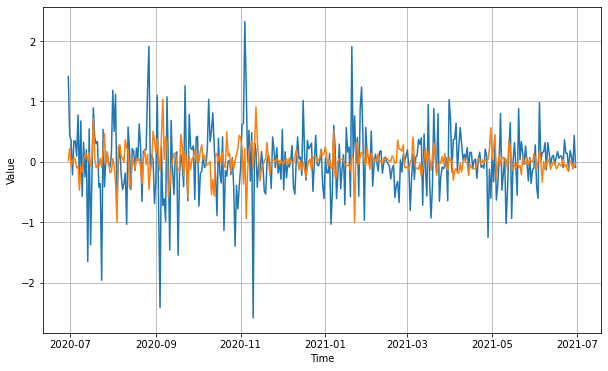

In [81]:
plt.figure(figsize=(10, 6))
plot_series(time_testing, microsoft_time_series_testing_lstm)
plot_series(time_testing, microsoft_LSTM_forecast)

Although again, model underestimates volataility of the stock data, in comparison to our previously analyzed Prophet models, it much more efficiently captures the behavior of the stock, and with some confidence we can say that it menaged to learn from it.

### Amazon

In [190]:
tf.keras.backend.clear_session()
tf.random.set_seed(95147)
np.random.seed(95147)
window_size = 32
batch_size = 128
shuffle_buffer_size = 1024
train_set = windowed_dataset(amazon_time_series_training_lstm, window_size, batch_size, shuffle_buffer_size)

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-6)

LSTM_network = initialize_network(
    window_size = window_size,
    n_features = 1,
    network_type = "LSTM",
    module_type = "inception"
)

LSTM_network.compile(
    loss=tf.keras.losses.Huber(),
    optimizer=optimizer,
    metrics=["mse"])

In [191]:
history = LSTM_network.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
29/29 [==============================] - 4s 24ms/step - loss: 0.3216 - mse: 1.0522
Epoch 2/100
29/29 [==============================] - 1s 27ms/step - loss: 0.3170 - mse: 1.0408
Epoch 3/100
29/29 [==============================] - 1s 28ms/step - loss: 0.3130 - mse: 1.0296
Epoch 4/100
29/29 [==============================] - 1s 27ms/step - loss: 0.3091 - mse: 1.0192
Epoch 5/100
29/29 [==============================] - 1s 26ms/step - loss: 0.3053 - mse: 1.0090
Epoch 6/100
29/29 [==============================] - 1s 27ms/step - loss: 0.3017 - mse: 0.9990
Epoch 7/100
29/29 [==============================] - 1s 26ms/step - loss: 0.2982 - mse: 0.9895
Epoch 8/100
29/29 [==============================] - 1s 25ms/step - loss: 0.2948 - mse: 0.9802
Epoch 9/100
29/29 [==============================] - 1s 27ms/step - loss: 0.2916 - mse: 0.9712
Epoch 10/100
29/29 [==============================] - 1s 26ms/step - loss: 0.2886 - mse: 0.9630
Epoch 11/100
29/29 [=============================

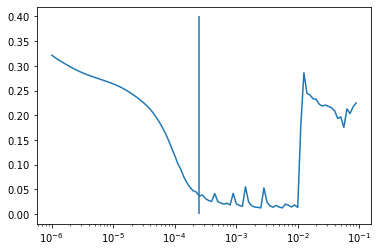

In [192]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.vlines(2.5*1e-4,0,0.4)

Here we can see that around $5*1e-4$ loss levels down, and learning rate starts to vary slightly, until it reaches $1e-2$ where it skyrockets.

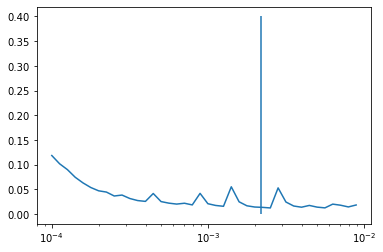

In [197]:
plt.semilogx(history.history["lr"][40:80], history.history["loss"][40:80])
plt.vlines(2.2*1e-3,0,0.4)

Given sligthly higher variation after $1e-3$ we will pick as our learning rate value of $2.2*1e-3$

Here we bergin the training. As the early stopping has been allowed, by monitoring change over validation set, we don't need to worry much about overfiting to the training data. The criterion for stoping is that for 10 subsequent iterations loss function over validation set doesn't improve more than $1e-4$.

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(95147)
np.random.seed(95147)
window_size = 64
batch_size = 128
shuffle_buffer_size = 1024

amazon_mse_list = []

for _ in range(50):
    train_set = windowed_dataset(amazon_time_series_training_lstm, window_size, batch_size, shuffle_buffer_size)
    test_set = windowed_dataset(amazon_time_series_testing_lstm, window_size, batch_size, shuffle_buffer_size)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=2.2*1e-3)

    LSTM_network = initialize_network(
        window_size = window_size,
        n_features = 1,
        network_type = "LSTM",
        module_type = "inception"
    )

    LSTM_network.compile(
        loss=tf.keras.losses.Huber(),
        optimizer=optimizer,
        metrics=["mse"])

    callback = tf.keras.callbacks.EarlyStopping(
        monitor="val_mse",
        min_delta=0.0001,
        patience=10,
        verbose=0,
        mode="auto",
        baseline=None,
        restore_best_weights=True,
    )


    LSTM_history = LSTM_network.fit(train_set,validation_data = test_set, epochs=600, callbacks = [callback])

    LSTM_forecast = model_forecast(LSTM_network, amazon_series[..., np.newaxis], window_size)
    LSTM_forecast = LSTM_forecast[split_time - window_size:-1, -1, 0]

    amazon_mse_list.append(mse(amazon_time_series_testing_lstm,LSTM_forecast))

Due to the shuffling, as well as stochastic properties of gradient descent, the need to properly assess model accuracy arises. For that reason, given architecture has been retrained 50 times, and each time we have gathered information about MSE on the test dataset. Down the line we will use mean value of those, as a way to assess 

In [200]:
np.mean(amazon_mse_list)

0.47034990317068653

In [201]:
np.save("amazon_testing_mse_for_lstm", np.array(amazon_mse_list))

In [82]:
amazon_mse_list = np.load("amazon_testing_mse_for_lstm.npy")

In [83]:
tf.keras.backend.clear_session()
tf.random.set_seed(95147)
np.random.seed(95147)
window_size = 64
batch_size = 128
shuffle_buffer_size = 1024

amazon_train_set = windowed_dataset(amazon_time_series_training_lstm, window_size, batch_size, shuffle_buffer_size)
amazon_test_set = windowed_dataset(amazon_time_series_testing_lstm, window_size, batch_size, shuffle_buffer_size)
    
optimizer = tf.keras.optimizers.Adam(learning_rate=2.2*1e-3)

amazon_LSTM_network = initialize_network(
    window_size = window_size,
    n_features = 1,
    network_type = "LSTM",
    module_type = "inception"
)

amazon_LSTM_network.compile(
        loss=tf.keras.losses.Huber(),
        optimizer=optimizer,
        metrics=["mse"])

callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_mse",
    min_delta=0.0001,
    patience=10,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)


amazon_LSTM_history = amazon_LSTM_network.fit(
    amazon_train_set,
    validation_data = amazon_test_set, 
    epochs=600, 
    callbacks = [callback]
)

amazon_LSTM_forecast = model_forecast(
    amazon_LSTM_network, 
    amazon_series[..., np.newaxis], 
    window_size
)

amazon_LSTM_forecast = amazon_LSTM_forecast[split_time - window_size:-1, -1, 0]

Epoch 1/600
29/29 [==============================] - 6s 69ms/step - loss: 0.3167 - mse: 1.0470 - val_loss: 0.1653 - val_mse: 0.3843
Epoch 2/600
29/29 [==============================] - 2s 44ms/step - loss: 0.2430 - mse: 0.8243 - val_loss: 0.1310 - val_mse: 0.3041
Epoch 3/600
29/29 [==============================] - 2s 45ms/step - loss: 0.2078 - mse: 0.7101 - val_loss: 0.0941 - val_mse: 0.2035
Epoch 4/600
29/29 [==============================] - 2s 44ms/step - loss: 0.1876 - mse: 0.6186 - val_loss: 0.0739 - val_mse: 0.1617
Epoch 5/600
29/29 [==============================] - 2s 44ms/step - loss: 0.1139 - mse: 0.3878 - val_loss: 0.0548 - val_mse: 0.1135
Epoch 6/600
29/29 [==============================] - 2s 43ms/step - loss: 0.0704 - mse: 0.2314 - val_loss: 0.0282 - val_mse: 0.0588
Epoch 7/600
29/29 [==============================] - 2s 45ms/step - loss: 0.0468 - mse: 0.1559 - val_loss: 0.0246 - val_mse: 0.0510
Epoch 8/600
29/29 [==============================] - 2s 45ms/step - loss: 0.

In [146]:
amazon_LSTM_network.save_weights("models/amazon/amazon_LSTM_network_weights")

As we can see, we in fact end the training early, after only 60 epochs. Now we can take a peak at how our training and validation loss changed over the epochs.

In [94]:
mse(amazon_time_series_testing_lstm,amazon_LSTM_forecast)

0.49900544340195846

In [88]:
np.mean(amazon_mse_list)

0.47034990317068653

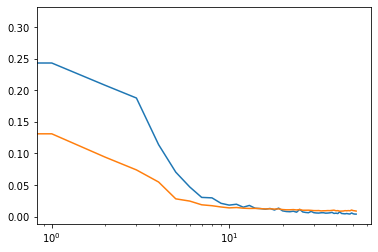

In [84]:
plt.semilogx(range(len(amazon_LSTM_history.history["loss"])), amazon_LSTM_history.history["loss"])
plt.semilogx(range(len(amazon_LSTM_history.history["val_loss"])), amazon_LSTM_history.history["val_loss"])

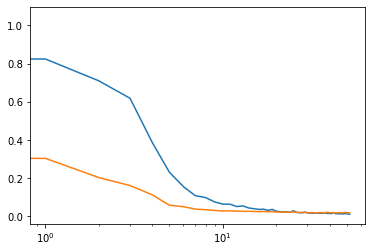

In [85]:
plt.semilogx(range(len(amazon_LSTM_history.history["mse"])), amazon_LSTM_history.history["mse"])
plt.semilogx(range(len(amazon_LSTM_history.history["val_mse"])), amazon_LSTM_history.history["val_mse"])

As we can see, we have quite intresting behavior, as initially we do better on validation set, than on training set. This changes over time, as model approaches fitted state.

Again, as for the previous model we can analyze what NeuralNetwork have learned over the training period, and how it generalizes to the testing data.

In [86]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

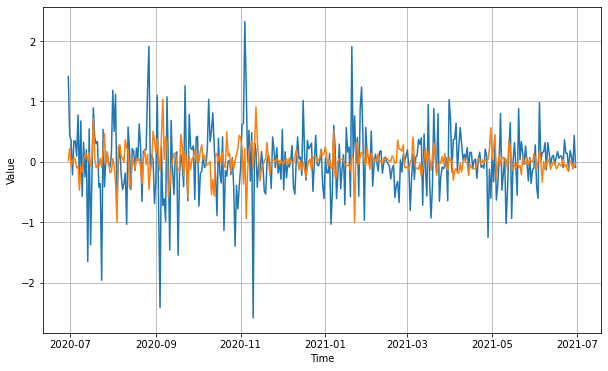

In [87]:
plt.figure(figsize=(10, 6))
plot_series(time_testing, microsoft_time_series_testing_lstm)
plot_series(time_testing, microsoft_LSTM_forecast)

Although again, model underestimates volataility of the stock data, in comparison to our previously analyzed Prophet models, it much more efficiently captures the behavior of the stock, and with some confidence we can say that it menaged to learn from it.

### Google

In [210]:
tf.keras.backend.clear_session()
tf.random.set_seed(95147)
np.random.seed(95147)
window_size = 32
batch_size = 128
shuffle_buffer_size = 1024
train_set = windowed_dataset(google_time_series_training_lstm, window_size, batch_size, shuffle_buffer_size)

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-6)

LSTM_network = initialize_network(
    window_size = window_size,
    n_features = 1,
    network_type = "LSTM",
    module_type = "inception"
)

LSTM_network.compile(
    loss=tf.keras.losses.Huber(),
    optimizer=optimizer,
    metrics=["mse"])

In [ ]:
history = LSTM_network.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
29/29 [==============================] - 4s 24ms/step - loss: 0.3253 - mse: 1.0119
Epoch 2/100
29/29 [==============================] - 1s 27ms/step - loss: 0.3204 - mse: 0.9988
Epoch 3/100
29/29 [==============================] - 1s 27ms/step - loss: 0.3158 - mse: 0.9861
Epoch 4/100
29/29 [==============================] - 1s 26ms/step - loss: 0.3113 - mse: 0.9739
Epoch 5/100
29/29 [==============================] - 1s 27ms/step - loss: 0.3070 - mse: 0.9620
Epoch 6/100
29/29 [==============================] - 1s 26ms/step - loss: 0.3027 - mse: 0.9504
Epoch 7/100
29/29 [==============================] - 1s 25ms/step - loss: 0.2986 - mse: 0.9392
Epoch 8/100
29/29 [==============================] - 1s 26ms/step - loss: 0.2946 - mse: 0.9282
Epoch 9/100
29/29 [==============================] - 1s 26ms/step - loss: 0.2908 - mse: 0.9177
Epoch 10/100
29/29 [==============================] - 1s 26ms/step - loss: 0.2872 - mse: 0.9077
Epoch 11/100
29/29 [=============================

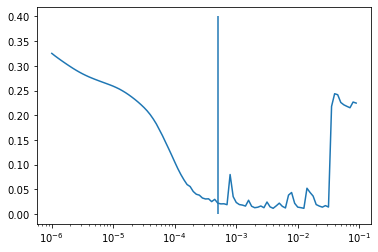

In [213]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.vlines(5*1e-4,0,0.4)

Here we can see that around $5*1e-4$ loss levels down, and learning rate starts to vary slightly, until it reaches $1e-2$ where it skyrockets.

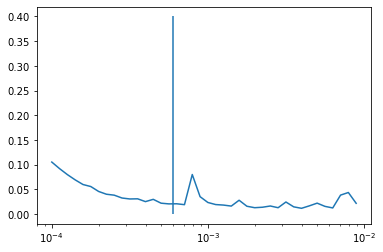

In [215]:
plt.semilogx(history.history["lr"][40:80], history.history["loss"][40:80])
plt.vlines(6*1e-4,0,0.4)

Given sligthly higher variation around $1e-3$ we will pick as our learning rate value of $6*1e-4$

Here we bergin the training. As the early stopping has been allowed, by monitoring change over validation set, we don't need to worry much about overfiting to the training data. The criterion for stoping is that for 10 subsequent iterations loss function over validation set doesn't improve more than $1e-4$.

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(95147)
np.random.seed(95147)
window_size = 64
batch_size = 128
shuffle_buffer_size = 1024

google_mse_list = []

for _ in range(50):
    train_set = windowed_dataset(google_time_series_training_lstm, window_size, batch_size, shuffle_buffer_size)
    test_set = windowed_dataset(google_time_series_testing_lstm, window_size, batch_size, shuffle_buffer_size)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=6*1e-4)

    LSTM_network = initialize_network(
        window_size = window_size,
        n_features = 1,
        network_type = "LSTM",
        module_type = "inception"
    )

    LSTM_network.compile(
        loss=tf.keras.losses.Huber(),
        optimizer=optimizer,
        metrics=["mse"])

    callback = tf.keras.callbacks.EarlyStopping(
        monitor="val_mse",
        min_delta=0.0001,
        patience=10,
        verbose=0,
        mode="auto",
        baseline=None,
        restore_best_weights=True,
    )


    LSTM_history = LSTM_network.fit(train_set,validation_data = test_set, epochs=600, callbacks = [callback])

    LSTM_forecast = model_forecast(LSTM_network, google_series[..., np.newaxis], window_size)
    LSTM_forecast = LSTM_forecast[split_time - window_size:-1, -1, 0]

    google_mse_list.append(mse(google_time_series_testing_lstm,LSTM_forecast))

Due to the shuffling, as well as stochastic properties of gradient descent, the need to properly assess model accuracy arises. For that reason, given architecture has been retrained 50 times, and each time we have gathered information about MSE on the test dataset. Down the line we will use mean value of those, as a way to assess 

In [223]:
np.save("google_testing_mse_for_lstm", np.array(google_mse_list))

In [89]:
google_mse_list = np.load("google_testing_mse_for_lstm.npy")

In [90]:
tf.keras.backend.clear_session()
tf.random.set_seed(95147)
np.random.seed(95147)
window_size = 64
batch_size = 128
shuffle_buffer_size = 1024

google_train_set = windowed_dataset(google_time_series_training_lstm, window_size, batch_size, shuffle_buffer_size)
google_test_set = windowed_dataset(google_time_series_testing_lstm, window_size, batch_size, shuffle_buffer_size)
    
optimizer = tf.keras.optimizers.Adam(learning_rate=6*1e-4)

google_LSTM_network = initialize_network(
    window_size = window_size,
    n_features = 1,
    network_type = "LSTM",
    module_type = "inception"
)

google_LSTM_network.compile(
        loss=tf.keras.losses.Huber(),
        optimizer=optimizer,
        metrics=["mse"])

callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_mse",
    min_delta=0.0001,
    patience=10,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)


google_LSTM_history = google_LSTM_network.fit(
    google_train_set,
    validation_data = google_test_set, 
    epochs=600, 
    callbacks = [callback]
)

google_LSTM_forecast = model_forecast(
    google_LSTM_network, 
    google_series[..., np.newaxis], 
    window_size
)

google_LSTM_forecast = google_LSTM_forecast[split_time - window_size:-1, -1, 0]

Epoch 1/600
29/29 [==============================] - 6s 68ms/step - loss: 0.3021 - mse: 0.9434 - val_loss: 0.3129 - val_mse: 0.8819
Epoch 2/600
29/29 [==============================] - 2s 43ms/step - loss: 0.2512 - mse: 0.8012 - val_loss: 0.2888 - val_mse: 0.8125
Epoch 3/600
29/29 [==============================] - 2s 44ms/step - loss: 0.2228 - mse: 0.7190 - val_loss: 0.2472 - val_mse: 0.7077
Epoch 4/600
29/29 [==============================] - 2s 45ms/step - loss: 0.1834 - mse: 0.5940 - val_loss: 0.2042 - val_mse: 0.5787
Epoch 5/600
29/29 [==============================] - 2s 44ms/step - loss: 0.1357 - mse: 0.4395 - val_loss: 0.1476 - val_mse: 0.4061
Epoch 6/600
29/29 [==============================] - 2s 43ms/step - loss: 0.0957 - mse: 0.3150 - val_loss: 0.1073 - val_mse: 0.2859
Epoch 7/600
29/29 [==============================] - 2s 43ms/step - loss: 0.0669 - mse: 0.2297 - val_loss: 0.0884 - val_mse: 0.2305
Epoch 8/600
29/29 [==============================] - 2s 43ms/step - loss: 0.

In [145]:
google_LSTM_network.save_weights("models/google/google_LSTM_network_weights")

In [144]:
np.mean(google_mse_list)

0.9299887167266866

In [91]:
mse(google_time_series_testing_lstm,google_LSTM_forecast)

0.8423810487613282

As we can see, we end the training early, after only 60 epochs. Now we can take a peak at how our training and validation loss changed over the epochs.

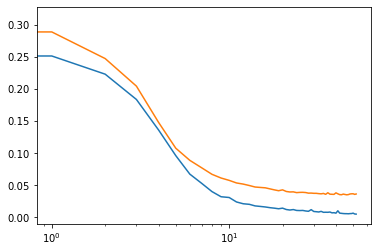

In [95]:
plt.semilogx(range(len(google_LSTM_history.history["loss"])), google_LSTM_history.history["loss"])
plt.semilogx(range(len(google_LSTM_history.history["val_loss"])), google_LSTM_history.history["val_loss"])

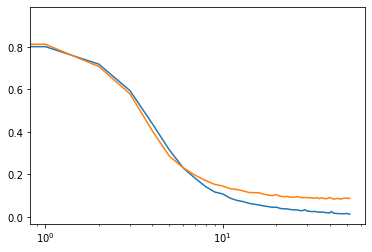

In [96]:
plt.semilogx(range(len(google_LSTM_history.history["mse"])), google_LSTM_history.history["mse"])
plt.semilogx(range(len(google_LSTM_history.history["val_mse"])), google_LSTM_history.history["val_mse"])

As we can see, we have quite interesting behavior, as initially, we do better on the validation set, than on the training set. This changes over time, as the model approaches the fitted state.

Again, as for the previous model we can analyze what NeuralNetwork has learned over the training period, and how it generalizes to the testing data.

In [97]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

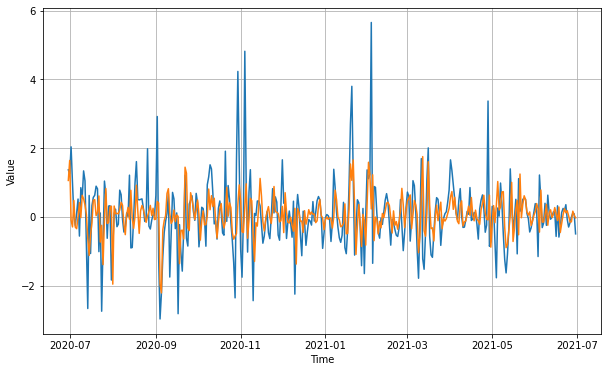

In [98]:
plt.figure(figsize=(10, 6))
plot_series(time_testing, google_time_series_testing_lstm)
plot_series(time_testing, google_LSTM_forecast)

Although again, model underestimates volataility of the stock data, in comparison to our previously analyzed Prophet models, it much more efficiently captures the behavior of the stock, and with some confidence we can say that it menaged to learn from it. Especially in case of Google we can see how well it interpolated more regular pattern of changes, prelevant to the time series, mimicking it nearly perfectly.

## Time Series Models

Here we will analyse properties of more traditional models used in modelling time series data. To be more precise, we will focus on SARIMA class models, derived from the concepts of ARIMA. Those models not only allow ARIMA based fluctuations, but also some degree of seasonality. But before that, we will make few key insights:
- as we have previously shown, time series we are dealing with may be deemed as in fact stationary, so we can say that we satisfy assumptions of the selected type of model,
- in general we determined that both Moving Average, as well as Autoregressive terms doesn't exceed the order of 3
- in general stationarity we could observe seemed to follow the order of 6 or 12 months. Due to the fact that this parameter needs to be set, we will try both of those intervals and choose the better of two,
- as we removed the trend, no differentiation should be necessary.

As the selection of hyperparameters can be an arduous task, again we will leverage AutoML functionalities of pmdarima package to do the job for us. We only need to restrict the parameters, so they allign with the observations we've made so far.

In [99]:
import pmdarima as pm

Here we train models for all 3 available companies:

In [100]:
microsoft_auto_model = pm.auto_arima(
    microsoft_time_series_training.y, 
    start_p=0, 
    start_q=0,
    max_p=3,
    max_q=3,
    m=6,
    start_P=0,
    seasonal=True,
    d=0,
    D=1,
    trace=True,
    error_action='ignore',
    suppress_warnings=False,
    stepwise=True
)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,1)[6] intercept   : AIC=inf, Time=2.16 sec
 ARIMA(0,0,0)(0,1,0)[6] intercept   : AIC=12935.487, Time=0.08 sec
 ARIMA(1,0,0)(1,1,0)[6] intercept   : AIC=11888.227, Time=0.53 sec
 ARIMA(0,0,1)(0,1,1)[6] intercept   : AIC=inf, Time=3.16 sec
 ARIMA(0,0,0)(0,1,0)[6]             : AIC=12933.487, Time=0.05 sec
 ARIMA(1,0,0)(0,1,0)[6] intercept   : AIC=12853.618, Time=0.15 sec
 ARIMA(1,0,0)(2,1,0)[6] intercept   : AIC=11568.497, Time=2.00 sec
 ARIMA(1,0,0)(2,1,1)[6] intercept   : AIC=inf, Time=14.10 sec


/home/moriarty/miniconda3/envs/tensorflow_cuda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(1,0,0)(1,1,1)[6] intercept   : AIC=inf, Time=3.48 sec
 ARIMA(0,0,0)(2,1,0)[6] intercept   : AIC=11629.943, Time=1.44 sec
 ARIMA(2,0,0)(2,1,0)[6] intercept   : AIC=11191.770, Time=2.56 sec
 ARIMA(2,0,0)(1,1,0)[6] intercept   : AIC=11544.350, Time=0.80 sec
 ARIMA(2,0,0)(2,1,1)[6] intercept   : AIC=inf, Time=12.93 sec


/home/moriarty/miniconda3/envs/tensorflow_cuda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,0,0)(1,1,1)[6] intercept   : AIC=inf, Time=7.38 sec
 ARIMA(3,0,0)(2,1,0)[6] intercept   : AIC=11192.030, Time=3.37 sec
 ARIMA(2,0,1)(2,1,0)[6] intercept   : AIC=11191.257, Time=6.54 sec
 ARIMA(2,0,1)(1,1,0)[6] intercept   : AIC=11544.399, Time=2.38 sec


/home/moriarty/miniconda3/envs/tensorflow_cuda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,0,1)(2,1,1)[6] intercept   : AIC=inf, Time=17.24 sec


/home/moriarty/miniconda3/envs/tensorflow_cuda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,0,1)(1,1,1)[6] intercept   : AIC=inf, Time=7.76 sec
 ARIMA(1,0,1)(2,1,0)[6] intercept   : AIC=11336.696, Time=4.18 sec


/home/moriarty/miniconda3/envs/tensorflow_cuda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(3,0,1)(2,1,0)[6] intercept   : AIC=inf, Time=19.84 sec


/home/moriarty/miniconda3/envs/tensorflow_cuda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,0,2)(2,1,0)[6] intercept   : AIC=inf, Time=18.02 sec
 ARIMA(1,0,2)(2,1,0)[6] intercept   : AIC=11165.511, Time=5.22 sec
 ARIMA(1,0,2)(1,1,0)[6] intercept   : AIC=inf, Time=4.22 sec


/home/moriarty/miniconda3/envs/tensorflow_cuda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(1,0,2)(2,1,1)[6] intercept   : AIC=inf, Time=16.08 sec


/home/moriarty/miniconda3/envs/tensorflow_cuda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(1,0,2)(1,1,1)[6] intercept   : AIC=inf, Time=10.02 sec
 ARIMA(0,0,2)(2,1,0)[6] intercept   : AIC=11193.953, Time=2.59 sec


/home/moriarty/miniconda3/envs/tensorflow_cuda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(1,0,3)(2,1,0)[6] intercept   : AIC=inf, Time=16.39 sec
 ARIMA(0,0,1)(2,1,0)[6] intercept   : AIC=11481.467, Time=2.00 sec
 ARIMA(0,0,3)(2,1,0)[6] intercept   : AIC=11169.631, Time=3.29 sec


/home/moriarty/miniconda3/envs/tensorflow_cuda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,0,3)(2,1,0)[6] intercept   : AIC=inf, Time=19.92 sec
 ARIMA(1,0,2)(2,1,0)[6]             : AIC=11163.515, Time=1.75 sec
 ARIMA(1,0,2)(1,1,0)[6]             : AIC=inf, Time=2.67 sec
 ARIMA(1,0,2)(2,1,1)[6]             : AIC=inf, Time=9.63 sec
 ARIMA(1,0,2)(1,1,1)[6]             : AIC=inf, Time=4.21 sec
 ARIMA(0,0,2)(2,1,0)[6]             : AIC=11191.957, Time=0.78 sec
 ARIMA(1,0,1)(2,1,0)[6]             : AIC=11334.701, Time=1.25 sec


/home/moriarty/miniconda3/envs/tensorflow_cuda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,0,2)(2,1,0)[6]             : AIC=inf, Time=7.66 sec


/home/moriarty/miniconda3/envs/tensorflow_cuda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(1,0,3)(2,1,0)[6]             : AIC=inf, Time=11.37 sec
 ARIMA(0,0,1)(2,1,0)[6]             : AIC=11479.469, Time=0.70 sec
 ARIMA(0,0,3)(2,1,0)[6]             : AIC=11167.634, Time=1.25 sec
 ARIMA(2,0,1)(2,1,0)[6]             : AIC=11189.260, Time=2.92 sec


/home/moriarty/miniconda3/envs/tensorflow_cuda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,0,3)(2,1,0)[6]             : AIC=inf, Time=13.15 sec

Best model:  ARIMA(1,0,2)(2,1,0)[6]          
Total fit time: 267.272 seconds


In [109]:
microsoft_auto_model_12 = pm.auto_arima(
    microsoft_time_series_training.y, 
    start_p=0, 
    start_q=0,
    max_p=3,
    max_q=3,
    m=12,
    start_P=0,
    seasonal=True,
    d=0,
    D=1,
    trace=True,
    error_action='ignore',
    suppress_warnings=False,
    stepwise=True
)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=7.68 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=13023.919, Time=0.12 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=11978.862, Time=2.57 sec


/home/moriarty/miniconda3/envs/tensorflow_cuda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=17.14 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=13021.920, Time=0.08 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=12965.124, Time=0.26 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=11605.362, Time=5.87 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=45.13 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=17.52 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=11646.029, Time=4.62 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=11248.009, Time=8.41 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=11614.254, Time=4.03 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=65.89 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=21.02 sec
 ARIMA(3,0,0)(2,1,0)[12] intercept   : AIC=11248.981, Time=10.34 sec
 ARIMA(2,0,1)(2,1,0)[12] intercept   : AIC=11247.196, Time=13.84 sec
 ARIMA(2,0,1)(1,1,0)[12] intercept   : AIC=11615.284, Time=6.98 sec


/home/moriarty/miniconda3/envs/tensorflow_cuda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,0,1)(2,1,1)[12] intercept   : AIC=inf, Time=55.02 sec
 ARIMA(2,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=27.25 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=11409.908, Time=11.34 sec
 ARIMA(3,0,1)(2,1,0)[12] intercept   : AIC=11241.492, Time=21.91 sec
 ARIMA(3,0,1)(1,1,0)[12] intercept   : AIC=11611.533, Time=12.36 sec


/home/moriarty/miniconda3/envs/tensorflow_cuda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(3,0,1)(2,1,1)[12] intercept   : AIC=inf, Time=64.70 sec


/home/moriarty/miniconda3/envs/tensorflow_cuda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(3,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=29.27 sec


/home/moriarty/miniconda3/envs/tensorflow_cuda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(3,0,2)(2,1,0)[12] intercept   : AIC=inf, Time=62.30 sec
 ARIMA(2,0,2)(2,1,0)[12] intercept   : AIC=11221.632, Time=20.21 sec
 ARIMA(2,0,2)(1,1,0)[12] intercept   : AIC=11596.489, Time=9.68 sec
 ARIMA(2,0,2)(2,1,1)[12] intercept   : AIC=inf, Time=72.15 sec


/home/moriarty/miniconda3/envs/tensorflow_cuda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=inf, Time=29.60 sec
 ARIMA(1,0,2)(2,1,0)[12] intercept   : AIC=11222.296, Time=13.31 sec
 ARIMA(2,0,3)(2,1,0)[12] intercept   : AIC=11211.032, Time=31.56 sec
 ARIMA(2,0,3)(1,1,0)[12] intercept   : AIC=11591.057, Time=18.12 sec


/home/moriarty/miniconda3/envs/tensorflow_cuda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,0,3)(2,1,1)[12] intercept   : AIC=inf, Time=66.40 sec
 ARIMA(2,0,3)(1,1,1)[12] intercept   : AIC=inf, Time=32.06 sec
 ARIMA(1,0,3)(2,1,0)[12] intercept   : AIC=11209.053, Time=31.26 sec
 ARIMA(1,0,3)(1,1,0)[12] intercept   : AIC=11589.150, Time=9.69 sec


/home/moriarty/miniconda3/envs/tensorflow_cuda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(1,0,3)(2,1,1)[12] intercept   : AIC=inf, Time=58.48 sec


/home/moriarty/miniconda3/envs/tensorflow_cuda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(1,0,3)(1,1,1)[12] intercept   : AIC=inf, Time=30.31 sec
 ARIMA(0,0,3)(2,1,0)[12] intercept   : AIC=11218.901, Time=10.47 sec
 ARIMA(0,0,2)(2,1,0)[12] intercept   : AIC=11240.491, Time=8.54 sec
 ARIMA(1,0,3)(2,1,0)[12]             : AIC=11207.075, Time=5.21 sec
 ARIMA(1,0,3)(1,1,0)[12]             : AIC=11587.161, Time=2.58 sec
 ARIMA(1,0,3)(2,1,1)[12]             : AIC=inf, Time=23.38 sec
 ARIMA(1,0,3)(1,1,1)[12]             : AIC=inf, Time=14.01 sec
 ARIMA(0,0,3)(2,1,0)[12]             : AIC=11216.927, Time=2.37 sec
 ARIMA(1,0,2)(2,1,0)[12]             : AIC=11220.322, Time=3.44 sec
 ARIMA(2,0,3)(2,1,0)[12]             : AIC=11209.054, Time=7.69 sec
 ARIMA(0,0,2)(2,1,0)[12]             : AIC=11238.520, Time=2.18 sec
 ARIMA(2,0,2)(2,1,0)[12]             : AIC=11219.658, Time=5.28 sec

Best model:  ARIMA(1,0,3)(2,1,0)[12]          
Total fit time: 1023.691 seconds


In [110]:
amazon_auto_model = pm.auto_arima(
    amazon_time_series_training.y, 
    start_p=0, 
    start_q=0,
    max_p=3,
    max_q=3,
    m=6,
    start_P=0,
    seasonal=True,
    d=0,
    D=1,
    trace=True,
    error_action='ignore',
    suppress_warnings=False,
    stepwise=True
)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,1)[6] intercept   : AIC=inf, Time=1.87 sec
 ARIMA(0,0,0)(0,1,0)[6] intercept   : AIC=13148.540, Time=0.06 sec
 ARIMA(1,0,0)(1,1,0)[6] intercept   : AIC=11851.031, Time=0.55 sec


/home/moriarty/miniconda3/envs/tensorflow_cuda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(0,0,1)(0,1,1)[6] intercept   : AIC=inf, Time=6.54 sec
 ARIMA(0,0,0)(0,1,0)[6]             : AIC=13146.540, Time=0.09 sec
 ARIMA(1,0,0)(0,1,0)[6] intercept   : AIC=12890.553, Time=0.20 sec
 ARIMA(1,0,0)(2,1,0)[6] intercept   : AIC=11482.433, Time=1.91 sec


/home/moriarty/miniconda3/envs/tensorflow_cuda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(1,0,0)(2,1,1)[6] intercept   : AIC=inf, Time=13.73 sec
 ARIMA(1,0,0)(1,1,1)[6] intercept   : AIC=inf, Time=4.54 sec
 ARIMA(0,0,0)(2,1,0)[6] intercept   : AIC=11732.559, Time=1.32 sec
 ARIMA(2,0,0)(2,1,0)[6] intercept   : AIC=11424.426, Time=2.44 sec
 ARIMA(2,0,0)(1,1,0)[6] intercept   : AIC=11788.821, Time=0.82 sec
 ARIMA(2,0,0)(2,1,1)[6] intercept   : AIC=inf, Time=15.97 sec
 ARIMA(2,0,0)(1,1,1)[6] intercept   : AIC=inf, Time=8.25 sec
 ARIMA(3,0,0)(2,1,0)[6] intercept   : AIC=11424.169, Time=2.97 sec
 ARIMA(3,0,0)(1,1,0)[6] intercept   : AIC=11789.567, Time=1.10 sec
 ARIMA(3,0,0)(2,1,1)[6] intercept   : AIC=inf, Time=18.86 sec


/home/moriarty/miniconda3/envs/tensorflow_cuda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(3,0,0)(1,1,1)[6] intercept   : AIC=inf, Time=10.06 sec
 ARIMA(3,0,1)(2,1,0)[6] intercept   : AIC=11425.721, Time=7.14 sec


/home/moriarty/miniconda3/envs/tensorflow_cuda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,0,1)(2,1,0)[6] intercept   : AIC=inf, Time=14.92 sec
 ARIMA(3,0,0)(2,1,0)[6]             : AIC=11422.169, Time=0.85 sec
 ARIMA(3,0,0)(1,1,0)[6]             : AIC=11787.567, Time=0.58 sec
 ARIMA(3,0,0)(2,1,1)[6]             : AIC=inf, Time=12.27 sec
 ARIMA(3,0,0)(1,1,1)[6]             : AIC=inf, Time=3.25 sec
 ARIMA(2,0,0)(2,1,0)[6]             : AIC=11422.426, Time=0.77 sec
 ARIMA(3,0,1)(2,1,0)[6]             : AIC=11423.721, Time=2.28 sec


/home/moriarty/miniconda3/envs/tensorflow_cuda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,0,1)(2,1,0)[6]             : AIC=inf, Time=9.01 sec

Best model:  ARIMA(3,0,0)(2,1,0)[6]          
Total fit time: 142.369 seconds


In [111]:
amazon_auto_model_12 = pm.auto_arima(
    amazon_time_series_training.y, 
    start_p=0, 
    start_q=0,
    max_p=3,
    max_q=3,
    m=12,
    start_P=0,
    seasonal=True,
    d=0,
    D=1,
    trace=True,
    error_action='ignore',
    suppress_warnings=False,
    stepwise=True
)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=8.78 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=13130.241, Time=0.11 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=11887.813, Time=2.74 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=10.77 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=13128.241, Time=0.08 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=12889.659, Time=0.25 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=11448.916, Time=5.92 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=28.55 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=12.87 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=11665.451, Time=4.64 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=11378.138, Time=7.70 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=11810.472, Time=3.67 sec


/home/moriarty/miniconda3/envs/tensorflow_cuda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=51.50 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=28.93 sec
 ARIMA(3,0,0)(2,1,0)[12] intercept   : AIC=11377.245, Time=8.91 sec
 ARIMA(3,0,0)(1,1,0)[12] intercept   : AIC=11809.890, Time=4.67 sec


/home/moriarty/miniconda3/envs/tensorflow_cuda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(3,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=59.03 sec


/home/moriarty/miniconda3/envs/tensorflow_cuda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(3,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=27.96 sec
 ARIMA(3,0,1)(2,1,0)[12] intercept   : AIC=11375.021, Time=33.16 sec
 ARIMA(3,0,1)(1,1,0)[12] intercept   : AIC=11809.801, Time=22.54 sec


/home/moriarty/miniconda3/envs/tensorflow_cuda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(3,0,1)(2,1,1)[12] intercept   : AIC=inf, Time=67.50 sec


/home/moriarty/miniconda3/envs/tensorflow_cuda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(3,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=33.38 sec
 ARIMA(2,0,1)(2,1,0)[12] intercept   : AIC=11376.750, Time=14.23 sec


/home/moriarty/miniconda3/envs/tensorflow_cuda/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/moriarty/miniconda3/envs/tensorflow_cuda/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(3,0,2)(2,1,0)[12] intercept   : AIC=11375.823, Time=49.87 sec
 ARIMA(2,0,2)(2,1,0)[12] intercept   : AIC=11378.305, Time=24.35 sec
 ARIMA(3,0,1)(2,1,0)[12]             : AIC=11373.034, Time=7.53 sec
 ARIMA(3,0,1)(1,1,0)[12]             : AIC=11807.806, Time=4.30 sec
 ARIMA(3,0,1)(2,1,1)[12]             : AIC=inf, Time=42.34 sec
 ARIMA(3,0,1)(1,1,1)[12]             : AIC=inf, Time=22.60 sec
 ARIMA(2,0,1)(2,1,0)[12]             : AIC=11374.763, Time=3.37 sec
 ARIMA(3,0,0)(2,1,0)[12]             : AIC=11375.257, Time=2.22 sec


/home/moriarty/miniconda3/envs/tensorflow_cuda/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/moriarty/miniconda3/envs/tensorflow_cuda/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(3,0,2)(2,1,0)[12]             : AIC=11373.834, Time=11.27 sec
 ARIMA(2,0,0)(2,1,0)[12]             : AIC=11376.150, Time=1.86 sec
 ARIMA(2,0,2)(2,1,0)[12]             : AIC=11376.318, Time=5.32 sec

Best model:  ARIMA(3,0,1)(2,1,0)[12]          
Total fit time: 612.960 seconds


In [112]:
google_auto_model = pm.auto_arima(
    google_time_series_training.y, 
    start_p=0, 
    start_q=0,
    max_p=3,
    max_q=3,
    m=6,
    start_P=0,
    seasonal=True,
    d=0,
    D=1,
    trace=True,
    error_action='ignore',
    suppress_warnings=False,
    stepwise=True
)

Performing stepwise search to minimize aic


/home/moriarty/miniconda3/envs/tensorflow_cuda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(0,0,0)(0,1,1)[6] intercept   : AIC=inf, Time=2.74 sec
 ARIMA(0,0,0)(0,1,0)[6] intercept   : AIC=13032.737, Time=0.06 sec
 ARIMA(1,0,0)(1,1,0)[6] intercept   : AIC=11555.366, Time=0.58 sec
 ARIMA(0,0,1)(0,1,1)[6] intercept   : AIC=inf, Time=4.98 sec
 ARIMA(0,0,0)(0,1,0)[6]             : AIC=13030.742, Time=0.07 sec
 ARIMA(1,0,0)(0,1,0)[6] intercept   : AIC=12617.031, Time=0.15 sec
 ARIMA(1,0,0)(2,1,0)[6] intercept   : AIC=11153.562, Time=2.08 sec


/home/moriarty/miniconda3/envs/tensorflow_cuda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(1,0,0)(2,1,1)[6] intercept   : AIC=inf, Time=15.00 sec


/home/moriarty/miniconda3/envs/tensorflow_cuda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(1,0,0)(1,1,1)[6] intercept   : AIC=inf, Time=3.49 sec
 ARIMA(0,0,0)(2,1,0)[6] intercept   : AIC=11556.363, Time=1.30 sec
 ARIMA(2,0,0)(2,1,0)[6] intercept   : AIC=11048.006, Time=2.57 sec
 ARIMA(2,0,0)(1,1,0)[6] intercept   : AIC=11461.576, Time=1.32 sec


/home/moriarty/miniconda3/envs/tensorflow_cuda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,0,0)(2,1,1)[6] intercept   : AIC=inf, Time=16.29 sec
 ARIMA(2,0,0)(1,1,1)[6] intercept   : AIC=inf, Time=4.39 sec
 ARIMA(3,0,0)(2,1,0)[6] intercept   : AIC=11044.427, Time=3.21 sec
 ARIMA(3,0,0)(1,1,0)[6] intercept   : AIC=11460.420, Time=1.75 sec


/home/moriarty/miniconda3/envs/tensorflow_cuda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(3,0,0)(2,1,1)[6] intercept   : AIC=inf, Time=18.76 sec


/home/moriarty/miniconda3/envs/tensorflow_cuda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(3,0,0)(1,1,1)[6] intercept   : AIC=inf, Time=5.40 sec
 ARIMA(3,0,1)(2,1,0)[6] intercept   : AIC=11035.333, Time=7.22 sec
 ARIMA(3,0,1)(1,1,0)[6] intercept   : AIC=11456.754, Time=3.61 sec


/home/moriarty/miniconda3/envs/tensorflow_cuda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(3,0,1)(2,1,1)[6] intercept   : AIC=inf, Time=24.01 sec


/home/moriarty/miniconda3/envs/tensorflow_cuda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(3,0,1)(1,1,1)[6] intercept   : AIC=inf, Time=8.65 sec
 ARIMA(2,0,1)(2,1,0)[6] intercept   : AIC=11046.609, Time=4.67 sec


/home/moriarty/miniconda3/envs/tensorflow_cuda/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/moriarty/miniconda3/envs/tensorflow_cuda/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/moriarty/miniconda3/envs/tensorflow_cuda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(3,0,2)(2,1,0)[6] intercept   : AIC=inf, Time=22.16 sec


/home/moriarty/miniconda3/envs/tensorflow_cuda/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/moriarty/miniconda3/envs/tensorflow_cuda/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/moriarty/miniconda3/envs/tensorflow_cuda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,0,2)(2,1,0)[6] intercept   : AIC=inf, Time=17.25 sec
 ARIMA(3,0,1)(2,1,0)[6]             : AIC=11033.335, Time=2.06 sec
 ARIMA(3,0,1)(1,1,0)[6]             : AIC=11454.756, Time=1.14 sec
 ARIMA(3,0,1)(2,1,1)[6]             : AIC=inf, Time=18.20 sec
 ARIMA(3,0,1)(1,1,1)[6]             : AIC=inf, Time=7.12 sec
 ARIMA(2,0,1)(2,1,0)[6]             : AIC=11044.611, Time=1.39 sec
 ARIMA(3,0,0)(2,1,0)[6]             : AIC=11042.429, Time=0.97 sec


/home/moriarty/miniconda3/envs/tensorflow_cuda/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/moriarty/miniconda3/envs/tensorflow_cuda/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/moriarty/miniconda3/envs/tensorflow_cuda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(3,0,2)(2,1,0)[6]             : AIC=inf, Time=11.07 sec
 ARIMA(2,0,0)(2,1,0)[6]             : AIC=11046.009, Time=0.74 sec


/home/moriarty/miniconda3/envs/tensorflow_cuda/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/moriarty/miniconda3/envs/tensorflow_cuda/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/moriarty/miniconda3/envs/tensorflow_cuda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,0,2)(2,1,0)[6]             : AIC=inf, Time=7.69 sec

Best model:  ARIMA(3,0,1)(2,1,0)[6]          
Total fit time: 222.110 seconds


In [113]:
google_auto_model_12 = pm.auto_arima(
    google_time_series_training.y, 
    start_p=0, 
    start_q=0,
    max_p=3,
    max_q=3,
    m=12,
    start_P=0,
    seasonal=True,
    d=0,
    D=1,
    trace=True,
    error_action='ignore',
    suppress_warnings=False,
    stepwise=True
)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=5.59 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=12964.879, Time=0.10 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=11517.191, Time=2.67 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=11.04 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=12962.880, Time=0.07 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=12584.768, Time=0.28 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=11108.300, Time=6.15 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=38.22 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=13.47 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=11508.583, Time=4.73 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=11011.769, Time=7.27 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=11424.669, Time=3.91 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=49.41 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=16.64 sec
 ARIMA(3,0,0)(2,1,0)[12] intercept  

/home/moriarty/miniconda3/envs/tensorflow_cuda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(3,0,1)(2,1,1)[12] intercept   : AIC=inf, Time=67.36 sec


/home/moriarty/miniconda3/envs/tensorflow_cuda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(3,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=32.41 sec
 ARIMA(2,0,1)(2,1,0)[12] intercept   : AIC=11008.571, Time=16.16 sec
 ARIMA(3,0,2)(2,1,0)[12] intercept   : AIC=10997.749, Time=29.87 sec
 ARIMA(3,0,2)(1,1,0)[12] intercept   : AIC=11406.367, Time=15.43 sec
 ARIMA(3,0,2)(2,1,1)[12] intercept   : AIC=inf, Time=50.70 sec


/home/moriarty/miniconda3/envs/tensorflow_cuda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(3,0,2)(1,1,1)[12] intercept   : AIC=inf, Time=37.77 sec
 ARIMA(2,0,2)(2,1,0)[12] intercept   : AIC=10999.435, Time=47.02 sec
 ARIMA(3,0,3)(2,1,0)[12] intercept   : AIC=10999.711, Time=53.78 sec
 ARIMA(2,0,3)(2,1,0)[12] intercept   : AIC=10997.909, Time=30.49 sec
 ARIMA(3,0,2)(2,1,0)[12]             : AIC=10995.749, Time=7.04 sec
 ARIMA(3,0,2)(1,1,0)[12]             : AIC=11404.367, Time=3.69 sec
 ARIMA(3,0,2)(2,1,1)[12]             : AIC=inf, Time=52.60 sec
 ARIMA(3,0,2)(1,1,1)[12]             : AIC=inf, Time=21.20 sec
 ARIMA(2,0,2)(2,1,0)[12]             : AIC=10997.436, Time=6.09 sec
 ARIMA(3,0,1)(2,1,0)[12]             : AIC=10996.243, Time=5.33 sec
 ARIMA(3,0,3)(2,1,0)[12]             : AIC=10997.711, Time=15.85 sec
 ARIMA(2,0,1)(2,1,0)[12]             : AIC=11006.572, Time=4.21 sec
 ARIMA(2,0,3)(2,1,0)[12]             : AIC=10995.909, Time=8.35 sec

Best model:  ARIMA(3,0,2)(2,1,0)[12]          
Total fit time: 809.121 seconds


In [151]:
joblib_dump(
    microsoft_auto_model, 
    "models/microsoft/microsoft_auto_model.joblib", 
    compress = ("gzip",5), 
    protocol = 3
)

joblib_dump(
    microsoft_auto_model_12, 
    "models/microsoft/microsoft_auto_model_12.joblib", 
    compress = ("gzip",5), 
    protocol = 3
)

joblib_dump(
    microsoft_auto_model, 
    "models/amazon/amazon_auto_model.joblib", 
    compress = ("gzip",5), 
    protocol = 3
)

joblib_dump(
    microsoft_auto_model_12, 
    "models/amazon/amazon_auto_model_12.joblib", 
    compress = ("gzip",5), 
    protocol = 3
)

joblib_dump(
    microsoft_auto_model, 
    "models/google/google_auto_model.joblib", 
    compress = ("gzip",5), 
    protocol = 3
)

joblib_dump(
    microsoft_auto_model_12, 
    "models/google/google_auto_model_12.joblib", 
    compress = ("gzip",5), 
    protocol = 3
)

['models/google/google_auto_model_12.joblib']

Here we make predictions for the estimated models:

In [114]:
microsoft_arima_forecast = microsoft_auto_model.predict(n_periods = 366)
microsoft_arima_12_forecast = microsoft_auto_model_12.predict(n_periods = 366)

google_arima_forecast = google_auto_model.predict(n_periods = 366)
google_arima_12_forecast = google_auto_model_12.predict(n_periods = 366)

amazon_arima_forecast = amazon_auto_model.predict(n_periods = 366)
amazon_arima_12_forecast = amazon_auto_model_12.predict(n_periods = 366)

Which we can analyse on the following plots:

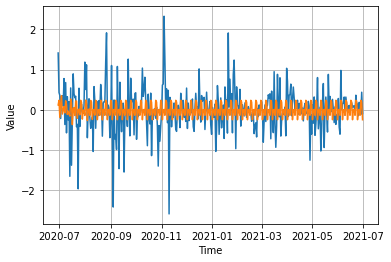

In [115]:
plot_series(time_testing, microsoft_time_series_testing.y)
plot_series(time_testing, microsoft_arima_forecast)

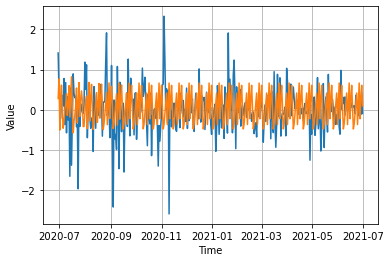

In [116]:
plot_series(time_testing, microsoft_time_series_testing.y)
plot_series(time_testing, microsoft_arima_12_forecast)

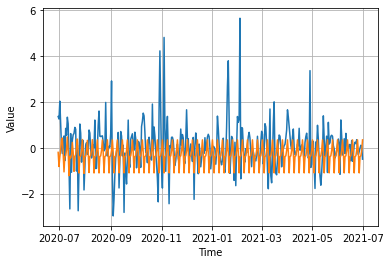

In [117]:
plot_series(time_testing, google_time_series_testing.y)
plot_series(time_testing, google_arima_forecast)

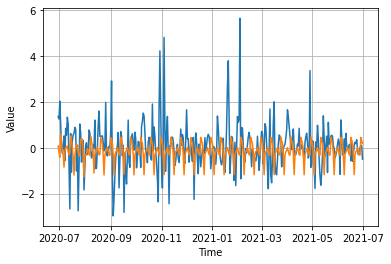

In [119]:
plot_series(time_testing, google_time_series_testing.y)
plot_series(time_testing, google_arima_12_forecast)

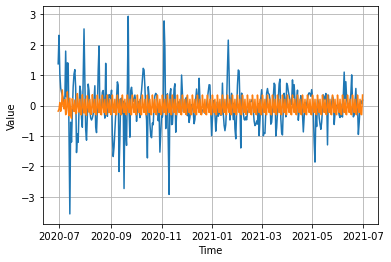

In [120]:
plot_series(time_testing, amazon_time_series_testing.y)
plot_series(time_testing, amazon_arima_forecast)

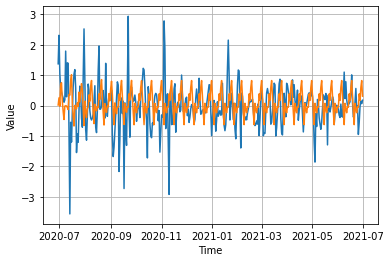

In [121]:
plot_series(time_testing, amazon_time_series_testing.y)
plot_series(time_testing, amazon_arima_12_forecast)

Looking at them, we can see, that all of the proposed models, rather than estimate observed fluctuation of values over time, focused only on their seasonal part, recreating it almost perfectly. It can be seen, as it is very little to no variation between subsequent predictions, other than some very obvious, repeating pattern.

Other than that, regardless of the company, we can see that although the model did far better than one derived by the Prophet package, capturing a lot more of the variation, again it failed in capturing properties of the underlying process.

## Model performance metric comparison

Lastly, we will make a comparison of selected metrics among all of the proposed models, compare them to a prediction by the raw mean, drawn over the training set, and based on that and previous observations write down the conclusions and recommendations.

In [178]:
statistics_dictionary = {
    "model_type": ["Mean","Prophet","LSTM","SARIMA_6","SARIMA_12"],
    "microsoft": [mse(microsoft_time_series_testing.y, np.repeat(np.mean(microsoft_time_series_training.y),366)),mse(microsoft_time_series_testing.y, microsoft_forecast.tail(366).yhat), np.mean(microsoft_mse_list), mse(microsoft_time_series_testing.y, microsoft_arima_forecast), mse(microsoft_time_series_testing.y, microsoft_arima_12_forecast)],
    "amazon": [mse(amazon_time_series_testing.y, np.repeat(np.mean(amazon_time_series_training.y),366)), mse(amazon_time_series_testing.y, amazon_forecast.tail(366).yhat), np.mean(amazon_mse_list), mse(amazon_time_series_testing.y, amazon_arima_forecast), mse(amazon_time_series_testing.y, amazon_arima_12_forecast)],
    "google": [mse(google_time_series_testing.y, np.repeat(np.mean(google_time_series_training.y),366)),mse(google_time_series_testing.y, google_forecast.tail(366).yhat), np.mean(google_mse_list), mse(google_time_series_testing.y, google_arima_forecast), mse(google_time_series_testing.y, google_arima_12_forecast)]
}

model_statistics = pd.DataFrame(statistics_dictionary).T
model_statistics.columns = model_statistics.iloc[0]
model_statistics.drop(model_statistics.index[0], inplace = True)

In [181]:
model_statistics_over_mean = model_statistics.copy(deep = True)
model_statistics_over_mean["Prophet"] = (model_statistics["Mean"]-model_statistics["Prophet"])/model_statistics["Mean"]*100
model_statistics_over_mean["LSTM"] = (model_statistics["Mean"]-model_statistics["LSTM"])/model_statistics["Mean"]*100
model_statistics_over_mean["SARIMA_6"] = (model_statistics["Mean"]-model_statistics["SARIMA_6"])/model_statistics["Mean"]*100
model_statistics_over_mean["SARIMA_12"] = (model_statistics["Mean"]-model_statistics["SARIMA_12"])/model_statistics["Mean"]*100
model_statistics_over_mean.drop("Mean", axis = 1, inplace = True)

In [185]:
model_statistics

model_type,Mean,Prophet,LSTM,SARIMA_6,SARIMA_12
microsoft,0.301674,0.314616,0.356586,0.332174,0.457003
amazon,0.540632,0.557203,0.47035,0.592445,0.722304
google,0.963502,0.986964,0.929989,1.234951,1.147544


In [183]:
model_statistics_over_mean>0

model_type,Prophet,LSTM,SARIMA_6,SARIMA_12
microsoft,False,False,False,False
amazon,False,True,False,False
google,False,True,False,False


In [184]:
model_statistics_over_mean

model_type,Prophet,LSTM,SARIMA_6,SARIMA_12
microsoft,-4.290144,-18.20242,-10.110503,-51.489287
amazon,-3.065072,13.000021,-9.583765,-33.60358
google,-2.435012,3.4783,-28.173139,-19.101383


**Observations**
As we can see only LSTM models of all of the considered ones attain any semblance of improvement in considered statistics over the prediction by mean, derived from the training data, and even this is not always the case, as we can see that in the case of Microsoft, LSTM did poorly, and for the Google, the improvement wasn't especially large. 

On the other hand, ARIMA based models did poorly in every situation, as regardless of the type of the selected model (from that class) they introduced more error than any other model (in nearly all of the cases), and as we have seen they couldn't consistently learn any meaningful properties of the underlying process for the given data.

Lastly, it is worth noting, that Prophet's seemingly "near-mean" performance is a consequence of the very low variation of the fitted model, or to put it in other words: the only thing that model could consistently abstract from the data was the mean and some very minor fluctuation around it. So the consequence of that is lack of improvement or rather much of a change from the mean at all.

**Recommendation**
As we have noted, only LSTM models were able to abstract any kind of meaningful relation, for the underlying process present in the presented data. Even though there was an exemption to that case, from what could be gathered from the presented experiment, we can recommend the given model, as applicable to the problem, and we can determine that it not only managed to learn something useful but also made an observable improvement over the raw-mean predictions. 

Despite that further research in the field would be recommended, as during the experiment heavy emphasis has been placed upon AutoML methods, as well as some other preprocessing steps that could yield better results. Also, some kind of ensemble model (SARIMA seasonality extraction + LSTM ability to learn patterns for example) based on boosting could yield even better results.